In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

# Camera Calibration

## TORUN after Restart

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane. -- corner points

# load calibration images
camera_cal_dir = glob.glob('./camera_cal/*.jpg')



In [3]:
for img_path in camera_cal_dir:
    img = mpimg.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # append points found into the list
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)


In [4]:
# Do camera calibration given object points and image points
# shape can only be 2d: 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### load test images 

In [ ]:
testimg_dir = glob.glob('./test_images/test*.jpg')

test_images = []
for img_dir in testimg_dir:
    test_images.append(mpimg.imread(img_dir))

## image undistortion

In [ ]:
test_images_undist = []
for img in test_images:
    test_images_undist.append(cv2.undistort(img, mtx, dist, None, mtx))

In [ ]:
f, axes = plt.subplots(2, 3)
f.set_figheight(5)
f.set_figwidth(15)
f.suptitle('Undistorted Test images')
i = 0
for axe in axes:
    for j in range(3):
        axe[j].imshow(test_images_undist[i+j])
    i += 3

### thresholding 

In [ ]:
# threshold 
def thresh(img, sx_thresh=(20, 100), s_thresh=(170, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary


In [ ]:
threshed_images = []
threshed_images_stack = []
for img in test_images_undist:
    color_binary, combined_binary_image = thresh(img)
    threshed_images.append(combined_binary_image)
    threshed_images_stack.append(color_binary)

#### visualise thresholded test images

In [ ]:
f, axes = plt.subplots(4, 2)
f.set_figheight(15)
f.set_figwidth(15)
f.suptitle('Thresholded Test images')
i = 0
for axe in axes:
    axe[0].imshow(threshed_images[i], cmap='gray')
    axe[0].set_title('Combined S color channel and gradient thresholds')
    axe[1].imshow(threshed_images_stack[i])
    axe[1].set_title('Stacked thresholds: blue is from S color channel')
    i += 1

### Persepective transform

## TORUN after Restart

Those same four source points will now work to transform any image (under the assumption that the road is flat and the camera perspective hasn't changed).

In [5]:
# read in an image with stright road to calculate the perspective transform
straight_road = mpimg.imread('./test_images/straight_lines1.jpg')

In [6]:
# define 4 source points
### top left - bottom left - bottom right - top right
src = np.float32([[592, 453],
                  [202, 720],
                  [1100, 720],
                  [685, 453]])
# define 4 destination points
dst = np.float32([[360, 0],
                  [360, 720],
                  [970, 720],
                  [970, 0]])
#     360, 970

In [7]:
# compute the perspective transform M
M = cv2.getPerspectiveTransform(src, dst)


Visualise the result

In [ ]:
# warp an image using the perspective transform, M
binary_warped = cv2.warpPerspective(straight_road, M, (straight_road.shape[1], straight_road.shape[0] ))#, flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped)

### transform for all test images

In [ ]:
test_images_transformed = []
for img in threshed_images:
    binary_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    test_images_transformed.append(binary_warped)

visualise the result

In [ ]:
f, axes = plt.subplots(6, 2)
f.set_figheight(23)
f.set_figwidth(15)
f.suptitle('Thresholded Test images')
i = 0
for axe in axes:
    axe[0].imshow(threshed_images[i], cmap='gray')
    axe[0].set_title('Combined S color channel and gradient thresholded image')
    axe[1].imshow(test_images_transformed[i], cmap='gray')
    axe[1].set_title('Perspective transformed')
    i += 1

### Pipeline
###### Put above steps together to process one image at a time

## TO RUN after Restart

In [8]:
def thresh_pipeline(img, sx_thresh=(20, 100), s_thresh=(170, 255)):
    '''pass in a RGB image and return the undistorted, thresholded, perspective transformed image'''
#     # image undistortion
#     img = cv2.undistort(img, mtx, dist, None, mtx)

    '''img is undistorted image'''
    # thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    '''
    Return those two later in order to show the contribution of s channel and gradient
    '''
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Perspective transform
    binary_warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]))
    
    return binary_warped

visualise the pipeline

In [ ]:
test = test_images[2]

In [ ]:
plt.imshow(test)

In [ ]:
test_result = thresh_pipeline(test)

In [ ]:
plt.imshow(test_result, cmap='gray')

## Sliding window

### Peaks in histgoram

In [ ]:
histgoram = np.sum(test_result[test_result.shape[0]//2:, :], axis=0)
plt.plot(histgoram)

output pipeline

## TORUN after Restart

In [9]:
# already computed M, and 
def pipeline(raw_img, sx_thresh=(20, 100), s_thresh=(170, 255)):
    undist = cv2.undistort(raw_img, mtx, dist, None, mtx)
    binary_warped = thresh_pipeline(undist, sx_thresh=(20, 100), s_thresh=(170, 255))
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    '''
    Todo: use figure.savefig('.jpg') to output sliding window images
    '''
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     plt.figure(figsize=(20,10))
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    '''uncomment above for save figure'''
    
    # find curvature
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image

    undist = np.copy(undist)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [10]:
test = mpimg.imread('./test_images/test2.jpg')

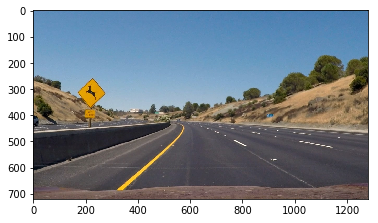

In [11]:
plt.imshow(test)

In [12]:
test_output = pipeline(test)

1466.73759431 1154.9487689
481.721644153 m 367.027660873 m


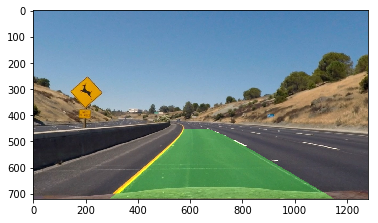

In [13]:
plt.imshow(test_output)

### visualise the pipeline for test images

In [14]:
testimg_dir = glob.glob('./test_images/test*.jpg')

test_images = []

for img_dir in testimg_dir:
    test_images.append(mpimg.imread(img_dir))

In [15]:
test_images_threshed = []

test_images_result = []
for img in test_images:
    test_images_result.append(pipeline(img))
    test_images_threshed.append(thresh_pipeline(img))

4491.40150005 7837.98251317
1394.77412972 m 2343.35116317 m
1322.75873874 938.356774402
429.347217668 m 302.905575871 m
3273.20548646 321.196386032
1074.16344653 m 40.8153484746 m
1515.69800794 1651.99003944
494.307350136 m 540.069991584 m
1866.53488377 2175.09372322
605.378035075 m 692.363120531 m
1466.73759431 1154.9487689
481.721644153 m 367.027660873 m


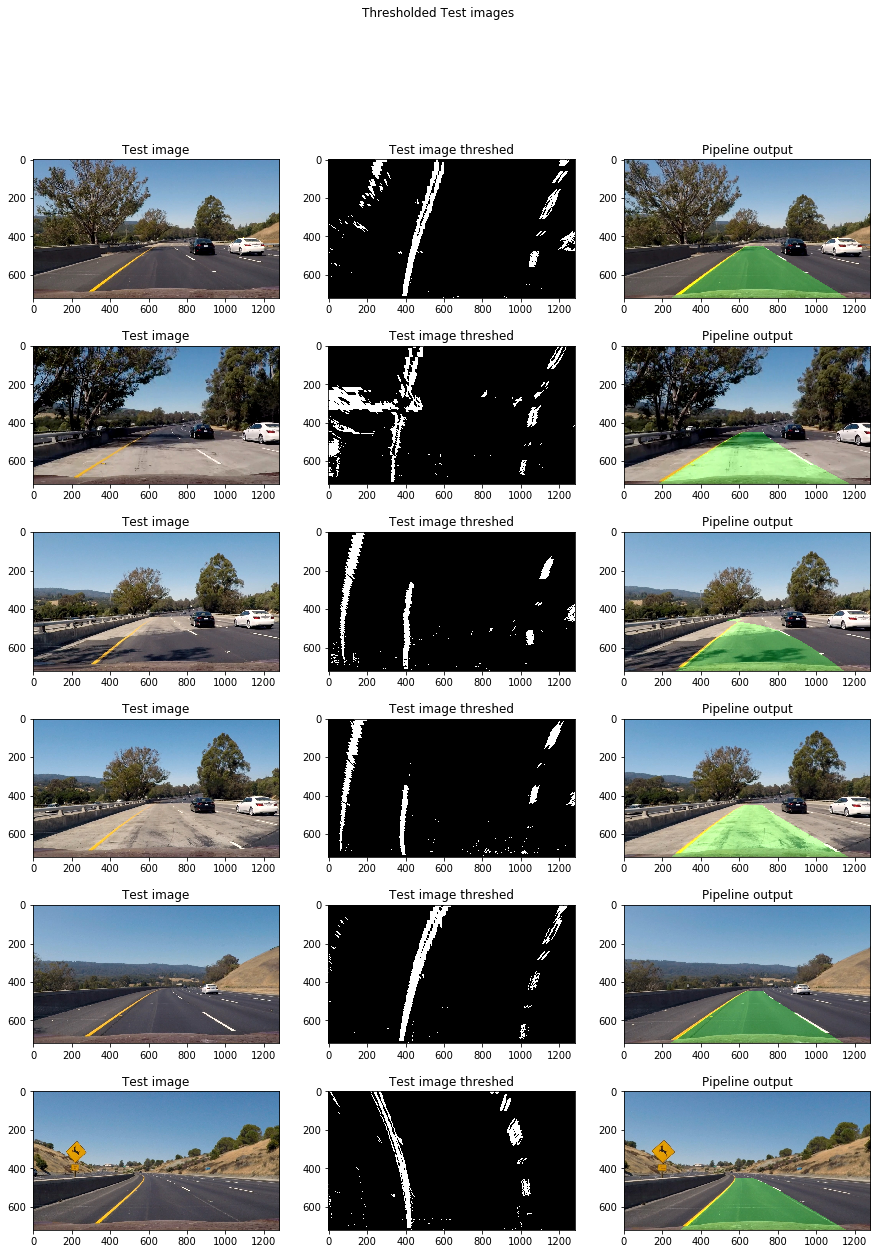

In [17]:
f, axes = plt.subplots(6, 3)
f.set_figheight(20)
f.set_figwidth(15)
f.suptitle('Thresholded Test images')
i = 0
for axe in axes:
    axe[0].imshow(test_images[i])
    axe[0].set_title('Test image')
    axe[1].imshow(test_images_threshed[i], cmap='gray')
    axe[1].set_title('Test image threshed')
    axe[2].imshow(test_images_result[i])
    axe[2].set_title('Pipeline output')
    i += 1

output video

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
output = 'output_images/try1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

1598.78871486 1746.90818826
525.061305642 m 573.708840107 m
[MoviePy] >>>> Building video output_images/try1.mp4
[MoviePy] Writing video output_images/try1.mp4


  0%|          | 1/1261 [00:00<02:46,  7.57it/s]

1598.78871486 1746.90818826
525.061305642 m 573.708840107 m


  0%|          | 2/1261 [00:00<02:47,  7.53it/s]

1461.3602592 2679.60215102
479.958062354 m 874.447602024 m


  0%|          | 3/1261 [00:00<02:43,  7.72it/s]

1419.11731638 3294.62286029
466.078429834 m 1067.29458763 m


  0%|          | 4/1261 [00:00<02:40,  7.83it/s]

1395.10562676 2668.98338848
458.133418454 m 868.664507126 m


  0%|          | 5/1261 [00:00<02:38,  7.92it/s]

1468.64965902 2188.48514628
482.355433524 m 715.920486804 m


  0%|          | 6/1261 [00:00<02:37,  7.98it/s]

1445.31318315 2434.36813934
474.653693266 m 791.984265733 m


  1%|          | 7/1261 [00:00<02:35,  8.07it/s]

1609.41407858 2753.97859799
527.584058278 m 893.684628525 m


  1%|          | 8/1261 [00:01<02:35,  8.07it/s]

1612.09801897 1332.29547163
528.119851865 m 436.703185459 m


  1%|          | 9/1261 [00:01<02:34,  8.11it/s]

1772.62767098 1625.01886704
578.760358991 m 533.727339486 m


  1%|          | 10/1261 [00:01<02:34,  8.11it/s]

1748.83525988 1452.33760082
570.951528274 m 476.957825991 m


  1%|          | 11/1261 [00:01<02:37,  7.92it/s]

2106.26748399 1696.89147863
682.561996211 m 555.952437808 m


  1%|          | 12/1261 [00:01<02:39,  7.81it/s]

2454.9980544 1455.31904171
788.83359884 m 477.365769964 m


  1%|          | 13/1261 [00:01<02:39,  7.81it/s]

2804.27611916 2042.95665457
895.374810928 m 668.047635574 m


  1%|          | 14/1261 [00:01<02:37,  7.92it/s]

2260.03263073 2523.30580354
727.83640829 m 819.449794665 m


  1%|          | 15/1261 [00:01<02:36,  7.96it/s]

2004.39565224 2678.00020428
649.901785837 m 860.952147426 m


  1%|▏         | 16/1261 [00:02<02:47,  7.42it/s]

1885.39708836 2008.38456039
613.168084203 m 651.166119495 m
1942.53571813 2099.03672862
630.645491415 m 679.229949871 m


  1%|▏         | 18/1261 [00:02<02:56,  7.04it/s]

1908.71238233 2030.84541486
619.915076265 m 656.682898453 m


  2%|▏         | 19/1261 [00:02<02:50,  7.30it/s]

2054.10107831 1988.09104729
665.665625717 m 646.662257013 m


  2%|▏         | 20/1261 [00:02<02:45,  7.48it/s]

2022.72155936 1634.22917848
654.915308134 m 536.159866742 m


  2%|▏         | 21/1261 [00:02<02:51,  7.23it/s]

2123.75738923 1541.78532835
685.997442796 m 506.387845416 m


  2%|▏         | 22/1261 [00:02<02:55,  7.07it/s]

2125.04321643 1678.29913369
686.636872026 m 551.241492087 m


  2%|▏         | 23/1261 [00:03<02:50,  7.26it/s]

2249.63879167 1406.27308429
725.122500633 m 460.08396832 m


  2%|▏         | 24/1261 [00:03<02:49,  7.29it/s]

2118.10195489 1184.70104921
685.642338625 m 385.062416643 m


  2%|▏         | 25/1261 [00:03<02:51,  7.19it/s]

1964.86728822 1488.00579072
638.878428043 m 488.733658771 m


  2%|▏         | 26/1261 [00:03<02:52,  7.17it/s]

2215.46165002 1462.29631661
717.019652588 m 479.778656443 m


  2%|▏         | 27/1261 [00:03<02:50,  7.22it/s]

2030.7875469 1718.74615093
660.08105592 m 564.444258037 m


  2%|▏         | 28/1261 [00:03<02:51,  7.18it/s]

1854.71282921 1747.76191589
604.803313773 m 573.895850126 m


  2%|▏         | 29/1261 [00:03<02:50,  7.23it/s]

1699.84779062 2478.90597891
556.347614405 m 810.517709639 m


  2%|▏         | 30/1261 [00:03<02:46,  7.41it/s]

1531.10372735 2510.8269885
502.318871743 m 818.908785057 m


  2%|▏         | 31/1261 [00:04<02:45,  7.42it/s]

1517.61869056 1695.94303243
498.059793646 m 556.498862595 m


  3%|▎         | 32/1261 [00:04<02:46,  7.37it/s]

1421.57717502 2144.09092552
466.894659151 m 696.711755042 m


  3%|▎         | 33/1261 [00:04<02:45,  7.41it/s]

1332.01622982 1976.02322092
437.475904375 m 646.32735481 m


  3%|▎         | 34/1261 [00:04<02:47,  7.30it/s]

1261.93498476 982.814514499
414.307746388 m 315.750272598 m


  3%|▎         | 35/1261 [00:04<02:54,  7.02it/s]

1213.24703625 1039.41764536
398.11158416 m 337.779991182 m


  3%|▎         | 36/1261 [00:04<03:02,  6.69it/s]

1166.16002373 1212.83248501
382.426548041 m 398.333981793 m


  3%|▎         | 37/1261 [00:05<03:04,  6.63it/s]

1098.872452 1456.01933515
359.874114484 m 476.637947629 m


  3%|▎         | 38/1261 [00:05<02:56,  6.94it/s]

1153.34988232 1779.95166118
378.348915762 m 576.753860966 m


  3%|▎         | 39/1261 [00:05<02:50,  7.16it/s]

1102.86190548 1504.76582188
361.580923195 m 490.227735718 m


  3%|▎         | 40/1261 [00:05<02:51,  7.12it/s]

1127.04770578 1394.73883291
369.897977175 m 456.318103843 m


  3%|▎         | 41/1261 [00:05<02:46,  7.31it/s]

1177.59336146 1447.24896548
386.745133002 m 472.824435771 m


  3%|▎         | 42/1261 [00:05<02:42,  7.51it/s]

1207.24437846 1522.35329107
396.52090877 m 496.675061583 m


  3%|▎         | 43/1261 [00:05<02:54,  6.98it/s]

1262.65300958 1618.21762523
414.500363774 m 527.239182306 m


  3%|▎         | 44/1261 [00:06<03:16,  6.19it/s]

1323.62906688 1769.65868519
433.993089991 m 576.864940611 m
1377.47130297 1967.98509355
450.862475867 m 639.818500304 m


  4%|▎         | 47/1261 [00:06<03:04,  6.58it/s]

1402.22220656 1441.09803538
458.67934151 m 473.158536324 m
1381.8095249 1110.59006047
452.169112164 m 362.703476939 m


  4%|▍         | 49/1261 [00:06<03:00,  6.71it/s]

1557.40432634 1075.91354651
507.298404241 m 351.971003882 m
1744.42589896 1124.37827126
564.97592176 m 368.082641539 m


  4%|▍         | 51/1261 [00:07<03:00,  6.71it/s]

1715.37874151 1231.23502196
555.643699993 m 404.362504858 m
1871.46073838 1583.97286647
603.215240992 m 517.959230343 m


  4%|▍         | 53/1261 [00:07<03:04,  6.54it/s]

1959.71044958 2073.00167041
629.787656832 m 667.37835698 m
1853.84669 1985.05530254
598.272876307 m 640.16237832 m


  4%|▍         | 55/1261 [00:07<02:56,  6.82it/s]

1949.20488507 1622.21730808
627.721509498 m 527.559534124 m
2183.66562647 1703.88338029
698.63142214 m 553.616022078 m


  5%|▍         | 57/1261 [00:07<02:53,  6.94it/s]

2182.64829541 1893.10401124
698.856875804 m 613.691498909 m
2102.40161739 2462.09544247
675.353162367 m 788.167411415 m


  5%|▍         | 59/1261 [00:08<02:47,  7.19it/s]

1990.94142921 1461.08798781
642.225195073 m 478.666795194 m
1798.11889282 1346.48319283
583.874018667 m 440.876786832 m


  5%|▍         | 61/1261 [00:08<02:44,  7.28it/s]

1790.74266318 1891.12411974
582.673937736 m 604.429194523 m
1840.31013209 3024.50160603
598.959545564 m 932.531620204 m


  5%|▍         | 63/1261 [00:08<02:50,  7.04it/s]

1787.96107968 2205.2784555
582.944768667 m 692.601701788 m
1897.35092572 2035.66565885
617.753151194 m 649.330573673 m


  5%|▌         | 65/1261 [00:09<02:49,  7.04it/s]

1774.73678553 1848.70748943
579.957413315 m 592.997076098 m
1937.2494545 1884.19499322
631.594265784 m 607.895286255 m


  5%|▌         | 67/1261 [00:09<02:53,  6.87it/s]

2058.99618883 1885.01032669
671.062681707 m 607.496771477 m
2062.59599054 1669.84662374
672.072920168 m 542.641217762 m


  5%|▌         | 69/1261 [00:09<02:45,  7.22it/s]

2266.43954541 1355.86053501
736.1871791 m 444.591355421 m
2201.91146378 1160.85254424
716.701863614 m 381.284588363 m


  6%|▌         | 71/1261 [00:09<02:38,  7.50it/s]

2398.09935249 1098.87565854
778.100568408 m 359.715370233 m
2433.41795403 1176.01220035
789.333691605 m 385.877385288 m


  6%|▌         | 73/1261 [00:10<02:35,  7.65it/s]

2396.40577353 1220.16614479
777.982291605 m 400.456184089 m
2259.90781832 1419.75698198
735.317174972 m 466.134306227 m


  6%|▌         | 74/1261 [00:10<02:49,  7.01it/s]

2255.57451323 1739.08681573
734.127655572 m 567.562765526 m


  6%|▌         | 75/1261 [00:10<03:14,  6.11it/s]

2579.99707492 1884.65800477
834.769927574 m 615.250440031 m


  6%|▌         | 76/1261 [00:10<03:32,  5.58it/s]

2680.23396 1808.09331761
866.890068979 m 590.591278379 m


  6%|▌         | 77/1261 [00:11<03:50,  5.13it/s]

3008.31035165 2143.95702355
967.578303923 m 699.770524081 m


  6%|▌         | 78/1261 [00:11<03:57,  4.99it/s]

2979.24513016 2272.90127566
959.105708762 m 742.36832386 m


  6%|▋         | 79/1261 [00:11<04:00,  4.91it/s]

3065.59686689 2158.80944456
986.744120879 m 707.040085775 m


  6%|▋         | 80/1261 [00:11<04:02,  4.87it/s]

2885.20675258 1968.89221183
931.945514171 m 645.89153151 m


  6%|▋         | 81/1261 [00:11<04:05,  4.80it/s]

2824.35394562 2007.28773498
914.113189553 m 657.736209108 m


  7%|▋         | 83/1261 [00:12<03:46,  5.21it/s]

2549.90166963 2248.52692738
829.102707591 m 735.568166886 m
2382.09622628 2412.2919129
776.345278983 m 787.447965291 m


  7%|▋         | 85/1261 [00:12<03:29,  5.61it/s]

2496.7314837 2868.77506107
812.51139071 m 936.549916492 m
2296.37074262 1758.81362831
749.387890924 m 577.520160063 m


  7%|▋         | 87/1261 [00:12<03:25,  5.71it/s]

1997.76470672 1440.09301079
654.544574181 m 470.932013477 m
1769.95629419 1454.04275946
581.297029008 m 477.401025613 m


  7%|▋         | 89/1261 [00:13<03:09,  6.18it/s]

1636.44523991 2124.66628664
537.398879773 m 692.136644568 m
1499.88529277 2394.77052759
491.914829378 m 775.203780184 m


  7%|▋         | 91/1261 [00:13<03:03,  6.36it/s]

1387.46754643 1930.79350599
454.013266274 m 627.283264011 m
1462.71851063 1739.57880681
479.419983923 m 569.119055926 m


  7%|▋         | 92/1261 [00:13<03:14,  6.01it/s]

1527.68223888 1855.3415665
501.318586543 m 606.567765311 m
1464.1458749 2097.99644718
480.084393326 m 683.084706022 m


  7%|▋         | 94/1261 [00:14<03:45,  5.18it/s]

1480.01824766 1254.43488556
485.449803187 m 411.895405253 m


  8%|▊         | 95/1261 [00:14<03:59,  4.88it/s]

1533.13746378 1205.65430876
503.278867848 m 394.456902193 m


  8%|▊         | 97/1261 [00:14<03:44,  5.20it/s]

1502.47188171 1042.27234859
493.136856879 m 335.185950501 m
1504.74264846 1142.26098082
493.93757489 m 371.719916422 m


  8%|▊         | 98/1261 [00:14<03:56,  4.92it/s]

1579.28284113 1239.20810233
518.699038124 m 404.505957338 m


  8%|▊         | 99/1261 [00:15<03:54,  4.95it/s]

1547.0582926 1457.68858603
508.02885137 m 478.759614703 m


  8%|▊         | 100/1261 [00:15<04:18,  4.48it/s]

1582.48128584 1558.46681564
519.745924087 m 511.883807651 m


  8%|▊         | 101/1261 [00:15<04:18,  4.49it/s]

1543.06164422 1950.34821355
506.762717284 m 638.297098548 m
1480.82612818 1629.18471369
486.132785786 m 534.928355026 m


  8%|▊         | 103/1261 [00:16<03:53,  4.95it/s]

1504.32141364 1524.45685544
493.941036178 m 500.711136808 m
1475.36758551 1464.43256648
484.384597685 m 480.878105603 m


  8%|▊         | 106/1261 [00:16<03:06,  6.21it/s]

1560.68771806 1543.71262683
512.602979775 m 506.661161505 m
1566.65849288 1566.97823921
514.572703426 m 514.028374787 m


  9%|▊         | 108/1261 [00:16<02:48,  6.83it/s]

1613.21009142 1552.43979563
529.812548373 m 508.402321972 m
1446.1712457 1616.57970863
474.842516208 m 530.565697104 m


  9%|▊         | 110/1261 [00:16<02:38,  7.27it/s]

1487.76607675 1071.38670219
488.599242134 m 339.522553582 m
1480.28100922 984.095441752
486.119093154 m 308.034032069 m


  9%|▉         | 112/1261 [00:17<02:43,  7.02it/s]

1525.84136049 1058.52797054
501.149322835 m 338.310227181 m
1601.82227017 1114.89563265
526.075807349 m 356.192851429 m


  9%|▉         | 114/1261 [00:17<02:41,  7.08it/s]

1474.07632095 1260.54574641
484.112001511 m 411.012532512 m
1450.52705051 1455.39678221
476.306716634 m 477.601430027 m


  9%|▉         | 116/1261 [00:17<02:42,  7.05it/s]

1390.83540413 1441.5306454
456.451823464 m 473.450173165 m
1391.00463299 1316.00828538
456.510531448 m 432.010291047 m


  9%|▉         | 118/1261 [00:18<02:39,  7.15it/s]

1389.51938719 1351.62592595
456.161034789 m 443.795076289 m
1390.43599747 1447.50778471
456.522526412 m 475.435091213 m


 10%|▉         | 120/1261 [00:18<02:40,  7.12it/s]

1401.17676981 1433.30549237
460.124996572 m 470.754333664 m
1282.39194311 1018.85614051
420.667564072 m 332.621810508 m


 10%|▉         | 122/1261 [00:18<02:35,  7.31it/s]

1352.49331802 951.498614356
444.099283329 m 307.158743649 m
1324.74338481 1003.90295556
434.974539922 m 327.248388387 m


 10%|▉         | 124/1261 [00:18<02:33,  7.43it/s]

1282.47106548 1278.02126014
420.91848668 m 419.408234889 m
1300.21869566 1424.20020406
426.883673283 m 465.867381534 m


 10%|▉         | 126/1261 [00:19<02:39,  7.12it/s]

1301.88301657 1453.52244596
427.460057449 m 474.2553213 m
1386.84174436 1688.8553404
455.496143197 m 550.202259121 m


 10%|█         | 127/1261 [00:19<03:45,  5.04it/s]

1317.04178685 1581.641512
432.571232528 m 515.962450336 m


 10%|█         | 128/1261 [00:19<04:06,  4.60it/s]

1339.57644477 1435.39663343
439.987109932 m 470.552352701 m


 10%|█         | 129/1261 [00:19<03:57,  4.76it/s]

1338.78344177 1519.8223013
439.711785265 m 495.158928516 m
1413.75545458 1548.74229712
464.192614443 m 505.485351948 m


 10%|█         | 132/1261 [00:20<03:14,  5.82it/s]

1464.69558404 1194.13039385
480.611780941 m 392.074024465 m
1510.58792108 1187.28282018
495.402835078 m 389.698885803 m


 11%|█         | 134/1261 [00:20<02:58,  6.31it/s]

1499.57910309 1204.32523763
491.860665001 m 395.486078924 m
1549.9034542 1469.1272179
508.025002433 m 479.006818703 m


 11%|█         | 136/1261 [00:21<02:54,  6.46it/s]

1531.90354058 1602.82466022
502.196716237 m 521.125855704 m
1728.60431428 1859.49402054
565.020360758 m 601.650676855 m


 11%|█         | 138/1261 [00:21<02:57,  6.31it/s]

1781.35879645 1940.92648002
581.823368826 m 629.966184782 m
1903.32863502 2306.70077203
620.495984972 m 746.962505071 m


 11%|█         | 140/1261 [00:21<02:53,  6.45it/s]

1910.78298262 2842.60651893
623.131155269 m 914.344263041 m
2060.49895873 3292.12492367
670.384525085 m 1061.01153627 m


 11%|█         | 141/1261 [00:21<02:59,  6.26it/s]

2021.34764472 3430.52342225
658.057684899 m 1104.0602107 m
2103.7665817 2168.22640511
684.778416053 m 708.104240391 m


 11%|█▏        | 143/1261 [00:22<03:12,  5.81it/s]

2090.61388653 2103.37128146
681.025574593 m 685.48079264 m


 11%|█▏        | 144/1261 [00:22<03:23,  5.49it/s]

1971.21008952 1863.1581483
643.653809134 m 609.387476911 m
2067.36159232 1285.21344387
674.608284638 m 421.569268108 m


 12%|█▏        | 147/1261 [00:22<03:07,  5.94it/s]

2007.56050756 1139.30754166
656.08746784 m 371.576073505 m
2045.92298791 1155.18445644
668.480343684 m 375.92755487 m


 12%|█▏        | 149/1261 [00:23<03:12,  5.77it/s]

1837.09862416 1679.67620261
602.350162703 m 548.115473349 m
1747.03029179 1987.44874767
573.29804264 m 643.586480831 m


 12%|█▏        | 151/1261 [00:23<03:04,  6.02it/s]

1751.94459901 2067.79312528
574.836805123 m 671.816869289 m
1849.15655697 1938.09295419
606.094327619 m 632.39825235 m


 12%|█▏        | 153/1261 [00:23<02:55,  6.32it/s]

2064.75113848 2191.52437295
675.225779334 m 713.853339012 m
1883.53954507 1676.85431272
617.222053521 m 549.235045698 m


 12%|█▏        | 155/1261 [00:24<02:47,  6.61it/s]

1919.33259167 1798.06038853
628.380511655 m 589.350682897 m
1896.91860653 2204.726122
620.739926482 m 720.353369513 m


 12%|█▏        | 157/1261 [00:24<02:40,  6.88it/s]

1904.43264131 2194.16790133
623.093018345 m 716.245971214 m
1826.13202489 2142.28035788
597.748006719 m 699.581678999 m


 13%|█▎        | 159/1261 [00:24<02:29,  7.36it/s]

1701.28787662 1208.43035209
557.985632863 m 396.506176889 m
1656.21788498 1156.28130998
543.342802581 m 377.968059432 m


 13%|█▎        | 161/1261 [00:25<02:33,  7.17it/s]

1554.21698125 1408.26293282
510.24281979 m 462.40186013 m
1674.81685382 1605.69718677
548.879903677 m 526.317245172 m


 13%|█▎        | 163/1261 [00:25<02:33,  7.15it/s]

1619.82064243 1790.97329128
531.054247657 m 585.334792163 m
1627.94075865 1977.50539893
533.396076949 m 646.028360533 m


 13%|█▎        | 165/1261 [00:25<02:35,  7.07it/s]

1692.30660551 1986.82467388
553.912985318 m 646.60474043 m
1544.57748573 1366.0452713
506.544482409 m 448.177850566 m


 13%|█▎        | 167/1261 [00:25<02:35,  7.02it/s]

1705.48585151 1459.44527826
557.752430822 m 478.327575429 m
1502.31608949 1224.05014293
492.898159232 m 401.882776987 m


 13%|█▎        | 169/1261 [00:26<02:36,  6.98it/s]

1770.74530124 1476.70801237
578.055450574 m 484.311283132 m
1741.82350977 1262.74517893
568.150366454 m 414.667374699 m


 13%|█▎        | 170/1261 [00:26<02:53,  6.30it/s]

1901.72564191 1227.57524545
617.997550482 m 402.016265904 m
1924.51422861 813.341881708
624.688905159 m

 14%|█▎        | 173/1261 [00:26<03:01,  5.99it/s]

 244.046301973 m
1809.21079706 800.724566794
588.768280456 m 242.070139931 m
1712.70970916 873.535786592
558.735217348 m 278.260193412 m


 14%|█▍        | 174/1261 [00:27<03:08,  5.76it/s]

1532.27589951 978.811733474
501.882563817 m 320.435220173 m
1451.75803894 890.231917567
476.158944987 m 290.435233345 m


 14%|█▍        | 176/1261 [00:27<03:10,  5.71it/s]

1389.08676547 919.13669446
455.965439625 m 301.114159799 m
1473.0016133 989.420785117
482.928171246 m 324.194198547 m


 14%|█▍        | 178/1261 [00:27<03:08,  5.74it/s]

1453.55559716 992.129462354
476.692805068 m 325.058996934 m
1422.48782963 1035.68311063
466.763023449 m 339.858345705 m


 14%|█▍        | 181/1261 [00:28<03:00,  5.98it/s]

1521.16645944 1138.93481035
498.531659035 m 374.066327 m
1335.58154101 1025.33723216
438.641163876 m 336.634477103 m


 14%|█▍        | 182/1261 [00:28<03:03,  5.88it/s]

1374.64529527 1088.48443046
451.438035425 m 357.418972594 m
1230.99933569 983.961932866


 15%|█▍        | 183/1261 [00:28<03:14,  5.54it/s]

404.076266191 m 323.073168615 m
1166.44131558 1193.68223356
382.306804802 m 389.353670675 m


 15%|█▍        | 185/1261 [00:29<03:13,  5.56it/s]

1121.29909807 1511.77645722
366.793965775 m 481.643677156 m
1008.20026639 1055.06713186
327.532972472 m 343.025051546 m


 15%|█▍        | 187/1261 [00:29<03:22,  5.29it/s]

1044.2390491 1218.84503501
340.192275249 m 392.645552344 m
1022.52565087 1284.67376979
332.699515656 m 409.604285916 m


 15%|█▍        | 189/1261 [00:29<03:21,  5.33it/s]

1053.64618528 1193.92374548
343.692763402 m 384.341232473 m
1039.46041452

 15%|█▌        | 190/1261 [00:29<03:23,  5.25it/s]

 1039.48050385
339.301122628 m 338.233182256 m
1050.71788123 1028.85001511
343.345493119 m 334.458245128 m


 15%|█▌        | 192/1261 [00:30<03:21,  5.30it/s]

1102.07062825 1025.17255575
361.188809154 m 334.288511534 m
1101.78503439 1065.57112067
361.32796582 m 345.858079092 m


 15%|█▌        | 194/1261 [00:30<03:30,  5.07it/s]

1156.53828392 1151.12748912
379.695844882 m 373.070599495 m
1173.75001604 1190.6566765
385.411815679 m 385.426445653 m


 16%|█▌        | 196/1261 [00:31<03:15,  5.44it/s]

1409.4860616 1075.62187051
462.087519587 m 353.261095819 m
1620.01176624 1061.62717155
528.504499502 m 347.462246504 m


 16%|█▌        | 198/1261 [00:31<03:24,  5.21it/s]

1730.97036771 1099.67849662
562.601135592 m 357.150362343 m


 16%|█▌        | 199/1261 [00:31<03:30,  5.05it/s]

1852.73615381 1536.10444094
599.329262387 m 503.999396358 m


 16%|█▌        | 200/1261 [00:31<03:40,  4.82it/s]

1878.54848425 1196.86526973
607.551440041 m 390.281195359 m


 16%|█▌        | 201/1261 [00:32<03:44,  4.72it/s]

1940.51452453 1319.77842561
626.514259539 m 431.850320653 m


 16%|█▌        | 203/1261 [00:32<03:27,  5.10it/s]

1780.27177511 1543.65735411
578.02665755 m 506.826762002 m
1661.49346959 1983.13685826
541.59796308 m 645.448494633 m


 16%|█▌        | 204/1261 [00:32<03:26,  5.12it/s]

1657.86940888 1695.49784322
540.562616913 m 554.510142576 m
1581.68798067 1413.48371567
516.893660925 m 463.263059908 m


 16%|█▋        | 207/1261 [00:33<03:02,  5.79it/s]

1500.75421993 1554.68295214
491.320368403 m 507.492601651 m
1367.27990172 1081.88288343
448.76285308 m 355.198405763 m


 16%|█▋        | 208/1261 [00:33<03:03,  5.75it/s]

1281.6217804 1183.24200236
420.936909749 m 387.173345621 m
1370.74255442 1251.11685493
449.860747384 m 409.341757608 m

 17%|█▋        | 210/1261 [00:33<03:00,  5.83it/s]


1382.15961214 1326.11358306
453.481157734 m 433.847789215 m
1452.36064645 1263.85604373
475.705794029 m 415.114690219 m


 17%|█▋        | 212/1261 [00:34<03:25,  5.11it/s]

1468.25330706 1530.01741305
480.734741481 m 499.483418066 m
1449.23464821 2105.92525871


 17%|█▋        | 213/1261 [00:34<03:21,  5.19it/s]

474.595182088 m 676.962831019 m
1421.75557857 2593.33376389
465.688618856 m 823.741865815 m


 17%|█▋        | 216/1261 [00:34<03:05,  5.64it/s]

1429.08976484 1986.81656106
467.982154345 m 639.334091682 m
1424.26432172 1874.70994684
466.192298844 m 605.641716432 m


 17%|█▋        | 217/1261 [00:35<03:06,  5.59it/s]

1447.70279624 2136.80197523
473.349903997 m 684.952691391 m
1541.2287101 2211.9973062
502.429984556 m 713.160039523 m


 17%|█▋        | 219/1261 [00:35<03:22,  5.15it/s]

1522.26502266 1509.19585299
496.591417652 m 491.885917931 m
1582.59430272 1502.84921213
514.782653042 m 492.660371129 m


 18%|█▊        | 222/1261 [00:35<03:08,  5.53it/s]

1673.37614941 1223.90553989
542.244135262 m 401.735262019 m
1783.49539204 1182.4243693
576.195480012 m 387.950203041 m


 18%|█▊        | 224/1261 [00:36<02:45,  6.27it/s]

1861.59200139 1339.43074253
600.093849947 m 439.859951306 m
1735.63130173 1896.86811164
562.0612645 m 611.668898464 m


 18%|█▊        | 225/1261 [00:36<02:47,  6.17it/s]

1739.972576 2138.51134695
563.656074852 m 687.743202655 m


 18%|█▊        | 226/1261 [00:36<03:11,  5.41it/s]

1793.34647175 1913.06932973
580.996274187 m 616.200209958 m


 18%|█▊        | 227/1261 [00:36<03:25,  5.03it/s]

1888.14360413 1758.28631304
610.255745608 m 570.647610155 m
1981.17591307 1775.49969402
638.93448411 m 577.722032353 m


 18%|█▊        | 229/1261 [00:37<03:15,  5.27it/s]

1978.15909338 1769.87400571
637.736104733 m 576.519230353 m
2162.28206594 1801.62419306
692.752257923 m 588.610333114 m


 18%|█▊        | 231/1261 [00:37<03:11,  5.37it/s]

2154.34611495 1645.08934292
691.011199069 m 538.231867377 m
2122.20002224 1185.46344779


 18%|█▊        | 233/1261 [00:37<03:03,  5.60it/s]

681.053774371 m 388.007672988 m
2184.38140515 931.145367392
700.522524849 m 296.169984952 m


 19%|█▊        | 234/1261 [00:38<02:59,  5.73it/s]

2100.0844826 1027.88506124
675.00385169 m 333.758266936 m
2015.10105264 1088.13764669
649.863981625

 19%|█▊        | 236/1261 [00:38<02:51,  5.99it/s]

 m 355.702140108 m
1838.57879335 1252.66627091
596.469045492 m 410.818396631 m
1775.45181719 1256.94945225
577.002144221 m 412.26432452 m


 19%|█▉        | 238/1261 [00:38<02:54,  5.85it/s]

1697.21022978 1155.15669797
552.948149267 m 379.169786883 m
1589.82174196 1173.77092389
519.67349292 m 384.760891004 m


 19%|█▉        | 240/1261 [00:39<02:52,  5.92it/s]

1550.85811963 1172.70388284
507.362137312 m 384.448809931 m
1539.66787621 1129.74006221
503.796626143

 19%|█▉        | 242/1261 [00:39<03:02,  5.58it/s]

 m 370.876321816 m
1632.56694114 1166.0023351
533.028132717 m 382.939802975 m
1528.93937656 1041.68286349
500.745031025 m 342.118854731 m


 19%|█▉        | 245/1261 [00:40<02:54,  5.81it/s]

1541.07705928 1061.8468041
504.638053622 m 348.745889809 m
1523.27539658 1229.02103825
499.343208192 m 401.630683678 m


 20%|█▉        | 247/1261 [00:40<03:00,  5.62it/s]

1448.05304387 1383.39221675
475.255709181 m 448.681095874 m
1500.42894413 1416.96670945
492.159242504 m 459.900850206 m


 20%|█▉        | 248/1261 [00:40<02:46,  6.07it/s]

1392.00788723 1125.61959364
457.12288643 m 368.596865836 m
1507.6823535 1251.98641504
494.57097626 m 409.508278129 m


 20%|█▉        | 250/1261 [00:40<03:06,  5.42it/s]

1532.57347159 1316.34939869
502.678960914 m 429.685305315 m


 20%|█▉        | 251/1261 [00:41<03:19,  5.05it/s]

1560.75069832 1351.21713724
511.791725806 m 441.386777836 m
1602.86412072 1379.03137754
525.246221085 m 451.162131131 m


 20%|██        | 253/1261 [00:41<03:24,  4.93it/s]

1690.63565882 1261.47338503
553.568883355 m 413.763533409 m
1793.4480081 1230.73320411
586.176788187 m 404.207787065 m


 20%|██        | 255/1261 [00:42<03:26,  4.88it/s]

1725.81672034 1059.82762542
565.240380879 m 347.808637186 m


 20%|██        | 257/1261 [00:42<03:04,  5.44it/s]

1805.67747203 1050.34632288
591.184288596 m 344.165097061 m
1762.41252511 1091.17551958
577.750375675 m 357.85898256 m


 20%|██        | 258/1261 [00:42<03:09,  5.28it/s]

1642.04187151 1331.71044193
539.126803041 m 436.597485095 m
1737.75232327 1436.27063451
570.316896586 m 470.595869824 m


 21%|██        | 260/1261 [00:42<02:58,  5.59it/s]

1697.65719701 1227.93087288
557.446712345 m 403.286605307 m
1738.58138118 1623.98117965
570.733509838 m 532.003958222 m


 21%|██        | 263/1261 [00:43<02:43,  6.11it/s]

1746.29591911 1429.2538026
573.413336196 m 469.231846652 m
1840.84780153 1408.55068545
604.272335065 m 462.585470936 m


 21%|██        | 265/1261 [00:43<02:39,  6.23it/s]

1849.51305686 1493.79402483
607.186049782 m 490.555444554 m
1904.20544999 1533.16790128
624.985976662 m 503.518214521 m


 21%|██        | 267/1261 [00:43<02:36,  6.36it/s]

1850.87956192 1799.4091261
607.578066003 m 590.783371905 m
1717.52848657 1409.35667659
564.128141498 m 462.65182353 m


 21%|██▏       | 268/1261 [00:44<02:46,  5.97it/s]

1771.49316932 1332.78289053
581.829448918 m 436.580615044 m
1754.64623157 1289.77822077


 21%|██▏       | 270/1261 [00:44<02:51,  5.78it/s]

576.316685458 m 420.572930495 m
1845.7092815 1257.89352943
606.198879843 m 409.349613531 m


 21%|██▏       | 271/1261 [00:44<02:55,  5.65it/s]

1757.03658088 1609.83557874
577.068866935 m 528.751256639 m


 22%|██▏       | 272/1261 [00:44<03:04,  5.37it/s]

1739.34748038 2300.93829023
571.050535832 m 746.176538273 m
1857.52452013 2215.39249182
610.080378345 m 721.141150346 m


 22%|██▏       | 275/1261 [00:45<02:50,  5.77it/s]

1855.30729593 2163.85526731
609.226720476 m 702.082075846 m
1893.21386426 2160.94641433
621.756842669 m 703.972933929 m


 22%|██▏       | 277/1261 [00:45<02:40,  6.11it/s]

2060.32750017 2327.86223834
676.677104398 m 759.731987222 m
2203.08028672 2025.66717094
723.297860428 m 664.160936676 m


 22%|██▏       | 279/1261 [00:46<02:23,  6.87it/s]

2281.56889055 2166.71364434
748.817874279 m 711.000451385 m
2289.23885398 1456.71163095
751.611239937 m 477.629955276 m


 22%|██▏       | 281/1261 [00:46<02:13,  7.36it/s]

2440.13180367 1521.04142311
801.004274861 m 498.946305268 m
2645.15231373 1569.92236595
868.053190445 m 514.914965745 m


 22%|██▏       | 283/1261 [00:46<02:06,  7.70it/s]

2580.54148886 2152.28737296
847.323285295 m 704.747747407 m
2894.87634707 2350.25891407
949.741693176 m 770.22810022 m


 23%|██▎       | 285/1261 [00:46<02:11,  7.41it/s]

2713.51742585 2513.21617186
890.9261668 m 822.626913887 m
2833.3421062 2739.50470555
930.004647566 m 897.80767611 m


 23%|██▎       | 287/1261 [00:47<02:07,  7.65it/s]

3027.55471655 3205.73556556
993.160960036 m 1050.64114485 m
3364.06884317 2610.2376813
1103.21311588 m 857.256133921 m


 23%|██▎       | 289/1261 [00:47<02:05,  7.77it/s]

3400.73148258 3165.60718071
1115.36255143 m 1039.45521956 m
3046.99506372 2469.02347826
1000.62364841 m 810.940172731 m


 23%|██▎       | 291/1261 [00:47<02:02,  7.93it/s]

3184.28444958 2226.40841678
1045.66522718 m 730.719641143 m
3135.94542825 1705.78830847
1030.01031003 m 558.260323565 m


 23%|██▎       | 293/1261 [00:47<02:07,  7.56it/s]

3048.38141454 1705.35510727
1001.15112737 m 558.194253156 m
3417.93303019 1667.75019771
1122.61368748 m 544.767245967 m


 23%|██▎       | 295/1261 [00:48<02:03,  7.85it/s]

3248.10416551 2038.33672412
1066.82818082 m 669.361097731 m
3066.46622156 2679.92378337
1007.08176381 m 879.523070626 m


 24%|██▎       | 297/1261 [00:48<02:07,  7.57it/s]

3235.56763489 3240.15335657
1062.6829132 m 1059.8629171 m
3285.09692787 3787.12856754
1078.98769214 m 1237.63820644 m


 24%|██▎       | 299/1261 [00:48<02:04,  7.72it/s]

3867.85940579 3690.7688025
1269.90596027 m 1207.85840545 m
4201.41679209 3154.09013018
1378.99291716 m 1034.60162883 m


 24%|██▍       | 301/1261 [00:48<02:02,  7.86it/s]

3925.36026294 3464.85631403
1288.28737172 m 1136.75201122 m
4571.86640498 4107.13851991
1499.15533409 m 1345.31686824 m


 24%|██▍       | 303/1261 [00:49<02:01,  7.88it/s]

5157.73368131 4622.88602435
1687.70698042 m 1515.63132821 m
4802.7052778 4108.94699335
1573.13494408 m 1347.43069681 m


 24%|██▍       | 305/1261 [00:49<02:00,  7.91it/s]

5046.15199217 3343.23116746
1653.1745766 m 1097.57601926 m
4766.90345635 3759.34194356
1561.46494016 m 1234.4098842 m


 24%|██▍       | 307/1261 [00:49<02:00,  7.94it/s]

6502.92003579 5861.52363118
2129.55068642 m 1910.67398963 m
6630.64191191 6496.25146805
2169.37775102 m 2123.22925325 m


 25%|██▍       | 309/1261 [00:49<01:59,  7.94it/s]

8942.29731435 23470.355742
2929.05031197 m 7463.79647173 m
11505.956088 201784.494094
3767.64661194 m 64951.6536815 m


 25%|██▍       | 311/1261 [00:50<01:59,  7.96it/s]

13493.990179 15790.3586741
4421.77094486 m 5126.0146743 m
11795.4944269 5636.40270437
3870.65938553 m 1843.04658651 m


 25%|██▍       | 313/1261 [00:50<01:59,  7.90it/s]

16486.4929684 6173.05132521
5409.482216 m 2019.57532602 m
39199.9397444 4225.996102
12867.0425685 m 1383.94489984 m


 25%|██▍       | 315/1261 [00:50<01:59,  7.91it/s]

95431.1292633 4630.75800757
31292.4281578 m 1518.26517962 m
213435.057259 5141.40126826
70009.8587504 m 1685.91415281 m


 25%|██▌       | 317/1261 [00:50<01:59,  7.88it/s]

53415.0179771 3758.22723131
17513.9750411 m 1234.0754194 m
77400.6330958 3032.27914224
25378.5569025 m 990.807581833 m


 25%|██▌       | 319/1261 [00:51<01:59,  7.86it/s]

112069.744416 3938.07715268
36796.3485056 m 1293.16071516 m
33065.6342095 4250.06842857
10852.5290854 m 1394.87937145 m


 25%|██▌       | 321/1261 [00:51<01:58,  7.93it/s]

33944.7747702 4391.36952241
11147.5031351 m 1442.32403342 m
20205.5258135 4381.740516
6632.99362988 m 1438.62955489 m


 26%|██▌       | 323/1261 [00:51<01:57,  8.01it/s]

23277.3588198 4005.8758458
7643.06892134 m 1314.78881842 m
24846.6328307 3581.19197061
8159.16383794 m 1173.79065448 m


 26%|██▌       | 325/1261 [00:51<01:58,  7.90it/s]

18305.6449529 6843.73095264
6006.90117561 m 2247.15220727 m
23006.5527711 4238.44821295
7553.84531356 m 1389.26552106 m


 26%|██▌       | 327/1261 [00:52<02:00,  7.76it/s]

16951.0149406 3889.65188824
5565.16828806 m 1274.02609484 m
27855.1620658 3896.91317326
9146.70578407 m 1274.50055934 m


 26%|██▌       | 329/1261 [00:52<01:57,  7.91it/s]

42344.2153533 4263.61916705
13906.5313972 m 1395.73650665 m
26006.9949594 2941.7948057
8533.65109567 m 947.595344165 m


 26%|██▌       | 331/1261 [00:52<01:57,  7.90it/s]

26472.7510625 5104.65772312
8692.50435064 m 1673.12822729 m
29454.3891018 1004624.11997
9674.13876402 m 328998.524798 m


 26%|██▋       | 333/1261 [00:52<01:56,  7.94it/s]

19673.4671066 14570.0955608
6461.00318857 m 4776.88952193 m
29325.7829333 14842.801568
9625.81878593 m 4864.89991942 m


 27%|██▋       | 335/1261 [00:53<02:00,  7.71it/s]

23469.9646308 8406.85767482
7706.04745072 m 2760.54925429 m
18072.2958692 6496.55915781
5935.11431853 m 2133.80614744 m


 27%|██▋       | 337/1261 [00:53<01:58,  7.79it/s]

32985.4982827 14806.6176339
10834.1082204 m 4863.25458014 m
15890.9312191 14080.260404
5218.66609111 m 4624.40685561 m


 27%|██▋       | 339/1261 [00:53<01:58,  7.75it/s]

10486.3255805 8564.22014047
3441.34463109 m 2810.37429988 m
14759.3106194 6006.14365896
4847.08932373 m 1968.03345503 m


 27%|██▋       | 341/1261 [00:53<02:04,  7.39it/s]

14307.631477 6243.45024647
4699.39030117 m 2048.94921247 m
16915.8120533 6150.12824272
5555.94461677 m 2015.98643221 m


 27%|██▋       | 343/1261 [00:54<02:08,  7.14it/s]

23729.050192 217910.551571
7787.98094729 m 71350.4533125 m
43726.1978113 8520837.01389
14352.4966403 m 2795415.81035 m


 27%|██▋       | 345/1261 [00:54<02:06,  7.26it/s]

93112.5273593 173518.543815
30570.3555138 m 56955.8155651 m
88328.5784305 41090.5676897
28998.8451167 m 13487.9571509 m


 28%|██▊       | 347/1261 [00:54<02:06,  7.23it/s]

32323.8921047 24601.7489301
10612.4586558 m 8078.57428755 m
19354.8894667 37622.6302531
6350.03293901 m 12357.0887304 m


 28%|██▊       | 349/1261 [00:55<02:06,  7.23it/s]

31373.6003296 49684.6086361
10302.5942956 m 16312.8268092 m
11995.363384 16161.1224008
3932.60038681 m 5305.49400209 m


 28%|██▊       | 351/1261 [00:55<02:04,  7.29it/s]

13336.8831073 9200.99097113
4376.62242711 m 3011.93235058 m
8383.40849397 6664.76460106
2746.93903561 m 2178.50465729 m


 28%|██▊       | 353/1261 [00:55<02:02,  7.38it/s]

9620.63139226 4296.62815025
3154.54615898 m 1396.058766 m
8580.02241512 3442.20790016
2814.23690556 m 1102.08418835 m


 28%|██▊       | 355/1261 [00:55<02:01,  7.43it/s]

14386.3327424 3536.81560018
4722.72949938 m 1138.3720779 m
13583.4769897 4521.43402099
4459.12525189 m 1464.3089907 m


 28%|██▊       | 357/1261 [00:56<02:02,  7.38it/s]

25772.397251 6549.48097941
8464.10110703 m 2136.52276585 m
17856.6375379 13711.8893028
5863.63713707 m 4498.46763249 m


 28%|██▊       | 359/1261 [00:56<02:00,  7.50it/s]

16574.5779661 12803.0210817
5440.89561529 m 4198.02500983 m
7307.04494243 10261.5802531
2395.60823389 m 3366.84322975 m


 29%|██▊       | 361/1261 [00:56<01:57,  7.63it/s]

6236.36460161 10172.5955648
2041.77530532 m 3333.37481993 m
5052.56510111 8137.64452797
1650.93939407 m 2664.38897413 m


 29%|██▉       | 363/1261 [00:56<02:02,  7.36it/s]

4132.58133311 5389.85179734
1349.27775847 m 1762.34138558 m
3485.47171314 4029.4455462
1133.87998005 m 1310.2167761 m


 29%|██▉       | 365/1261 [00:57<02:04,  7.20it/s]

3106.79916797 8979.56626981
1012.65878649 m 2948.27778383 m
3166.04108632 14653.4542762
1031.50582963 m 4812.50221789 m


 29%|██▉       | 366/1261 [00:57<02:08,  6.96it/s]

3229.56178514 21152.5274959
1054.15729352 m 6933.55760316 m


 29%|██▉       | 367/1261 [00:57<02:31,  5.90it/s]

3372.5179694 15789.6749447
1101.20718861 m 5177.84023778 m
3424.89085429 15551.2119445
1118.10661212 m 5104.27627139 m


 29%|██▉       | 370/1261 [00:58<02:20,  6.36it/s]

3917.55812041 44689.5982789
1284.14628414 m 14673.8353898 m
4319.01923419 75879.8809503
1416.535493 m 24921.1741562 m


 29%|██▉       | 371/1261 [00:58<02:21,  6.31it/s]

5769.39715094 18786.013141
1894.81773492 m 6167.57836293 m


 30%|██▉       | 373/1261 [00:58<02:29,  5.96it/s]

6481.23648479 13944.9042609
2128.56601097 m 4579.69775761 m
6909.04283446 17925.7526968
2269.13727548 m 5887.77268583 m


 30%|██▉       | 374/1261 [00:58<02:18,  6.40it/s]

10267.0221899 20265.3895599
3371.04866997 m 6648.59584786 m


 30%|██▉       | 375/1261 [00:58<02:38,  5.59it/s]

13407.0774334 6194.57695879
4398.20967258 m 2024.561154 m
22119.4992361 12741.9632636


 30%|██▉       | 377/1261 [00:59<02:40,  5.51it/s]

7234.40502151 m 4184.30230893 m
356998.0932 166249.519598
116481.021978 m 54596.2054949 m


 30%|███       | 379/1261 [00:59<02:21,  6.24it/s]

25559.0674905 13181.8999415
8315.36082668 m 4317.47471007 m
15649.2383745 13801.7572907
5090.88829361 m 4529.39155461 m


 30%|███       | 381/1261 [00:59<02:18,  6.36it/s]

13480.5835331 13425.8446418
4389.99125479 m 4406.78819893 m
12103.7451014 10115.0263963
3945.30030245 m 3321.0232175 m


 30%|███       | 383/1261 [01:00<02:11,  6.67it/s]

15902.6838162 9856.94001291
5194.6149376 m 3236.65599356 m
14465.561301 12147.7126407
4721.43876822 m 3988.95014669 m


 31%|███       | 385/1261 [01:00<01:59,  7.32it/s]

11860.631557 249678.619097
3869.12941749 m 81974.7160675 m
8400.99226395 16405.9070258
2737.51024405 m 5388.39588318 m


 31%|███       | 387/1261 [01:00<01:53,  7.71it/s]

9245.42604598 30684.7761959
3020.97066744 m 10076.3163328 m
10171.8113519 83482.4819669
3330.86413934 m 27383.2846193 m


 31%|███       | 389/1261 [01:00<01:50,  7.93it/s]

8416.5023387 711077.196372
2754.09610065 m 233352.210988 m
8046.06135144 15587.9702461
2635.02543299 m 5096.81650296 m


 31%|███       | 391/1261 [01:01<01:49,  7.92it/s]

8179.52174784 16186.773645
2682.07708982 m 5284.80246109 m
9247.55154956 7839.88831189
3034.84134277 m 2552.39029531 m


 31%|███       | 393/1261 [01:01<01:50,  7.88it/s]

7967.12825857 8577.37090576
2615.19663653 m 2794.50163536 m
9938.60660581 32945.7805534
3263.05683459 m 10810.3351143 m


 31%|███▏      | 395/1261 [01:01<01:49,  7.92it/s]

10517.3765952 17480.1539632
3454.23708406 m 5741.34750474 m
12812.3250017 7585.21150859
4208.25232179 m 2489.23444367 m


 31%|███▏      | 397/1261 [01:01<01:49,  7.87it/s]

15592.1758052 5289.01921536
5120.98962478 m 1733.97599013 m
25947.9134994 5814.67941437
8516.75482408 m 1908.18138197 m


 32%|███▏      | 399/1261 [01:02<01:47,  7.99it/s]

30244.2314876 7535.60414534
9925.25106575 m 2474.3936164 m
27592.8272833 6750.24690924
9052.59978699 m 2216.91758208 m


 32%|███▏      | 401/1261 [01:02<01:47,  7.97it/s]

31252.1345319 10625.9268041
10255.4374215 m 3489.5151805 m
34827.9573142 25612.5927444
11424.6882285 m 8399.03057503 m


 32%|███▏      | 403/1261 [01:02<01:50,  7.77it/s]

42181.5605772 11345.344341
13831.7623864 m 3724.89913281 m
127947.527054 6397.51299673
41937.0783785 m 2074.06614807 m


 32%|███▏      | 405/1261 [01:02<01:49,  7.82it/s]

56432.8177319 6205.26762216
18477.633289 m 2005.3235688 m
196519.365853 5630.10987473
64424.4571784 m 1825.71116517 m


 32%|███▏      | 407/1261 [01:03<01:48,  7.89it/s]

34688.7038059 13733.4872602
11352.1623427 m 4483.73632766 m
28044.4519225 37276.8405823
9174.55855649 m 12198.5215963 m


 32%|███▏      | 409/1261 [01:03<01:47,  7.90it/s]

27226.0992804 20538.14636
8906.42598989 m 6741.07697848 m
34954.9012259 10682.6556541
11439.7741641 m 3508.15854619 m


 33%|███▎      | 411/1261 [01:03<01:46,  7.96it/s]

101141.540204 6928.43456902
33145.7229874 m 2275.22863595 m
599290.450771 14378.9203543
196476.604287 m 4721.78343753 m


 33%|███▎      | 413/1261 [01:04<01:46,  7.95it/s]

34085.9873318 36811.4228377
11186.1262401 m 12077.3888455 m
27416.5235299 8484.09906408
9000.08099897 m 2786.32101166 m


 33%|███▎      | 415/1261 [01:04<01:46,  7.93it/s]

16277.1989908 15580.733843
5345.56094345 m 5115.43184195 m
17791.9472714 5725.2877226
5843.77725718 m 1859.67582715 m


 33%|███▎      | 417/1261 [01:04<01:46,  7.93it/s]

16858.1361741 6341.62703544
5536.32384235 m 2056.32332297 m
19783.5618086 7013.62640682
6497.80292653 m 2287.10049781 m


 33%|███▎      | 419/1261 [01:04<01:46,  7.92it/s]

11661.1940607 11629.8978061
3830.13601685 m 3804.25440199 m
14503.0572602 23260.4374376
4762.85524789 m 7637.90953748 m


 33%|███▎      | 421/1261 [01:05<01:46,  7.88it/s]

11338.9092988 9465.90103655
3724.26477779 m 3108.45610246 m
9475.64764661 6903.76091181
3111.99934797 m 2266.4315535 m


 33%|███▎      | 422/1261 [01:05<01:48,  7.73it/s]

9397.86531396 13727.2235661
3085.9830639 m 4508.40008374 m


 34%|███▎      | 424/1261 [01:05<02:17,  6.07it/s]

9137.36911693 75291.06721
3000.90214479 m 24695.3323275 m
11876.6001435 14394.4422418
3900.887093 m 4727.77833302 m


 34%|███▍      | 426/1261 [01:05<02:01,  6.85it/s]

10091.4454404 25288.0140624
3314.57000517 m 8302.87326013 m
10905.6165429 16605.3552626
3580.97664808 m 5448.68760077 m


 34%|███▍      | 428/1261 [01:06<01:52,  7.40it/s]

19025.2596034 5785.59668054
6242.15977137 m 1871.75661753 m
96326.9429524 5092.53577979
31569.3959761 m 1648.77580003 m


 34%|███▍      | 430/1261 [01:06<01:48,  7.69it/s]

79163.9740782 8512.14395855
25937.3084158 m 2779.12464994 m
32372.9166176 14602.8137568
10597.738713 m 4779.6098821 m


 34%|███▍      | 432/1261 [01:06<01:45,  7.85it/s]

41232.2942238 22757.8459832
13477.8973525 m 7446.42607498 m
16499.9789093 24878.9464521
5387.74180031 m 8166.5500653 m


 34%|███▍      | 434/1261 [01:06<01:44,  7.88it/s]

15527.8820586 33122.8027533
5055.52679212 m 10854.2980351 m
10868.9737275 123550.004281
3538.15462267 m 40496.0661532 m


 35%|███▍      | 436/1261 [01:07<01:43,  7.96it/s]

8912.98042485 28902.6426392
2898.41272772 m 9453.96200405 m
8633.76005266 25124.3272958
2813.67804611 m 8220.03136027 m


 35%|███▍      | 438/1261 [01:07<01:42,  8.04it/s]

7534.13460257 4580.54840851
2460.39974351 m 1481.95145748 m
7525.97288502 3400.47418815
2455.09123606 m 1084.41765249 m


 35%|███▍      | 440/1261 [01:07<01:41,  8.08it/s]

6880.17301929 4801.06840373
2250.74031869 m 1560.73758732 m
6778.802302 37378.8293625
2222.12659467 m 12277.0537998 m


 35%|███▌      | 442/1261 [01:07<01:40,  8.14it/s]

6609.95862295 34427.9913241
2164.91951206 m 11306.6134989 m
8177.7324208 299897.473889
2681.52375136 m 98499.6201972 m


 35%|███▌      | 444/1261 [01:08<01:39,  8.19it/s]

6315.27270861 28449.1403087
2061.00555486 m 9321.86082674 m
6905.40077687 1307100.82479
2258.50549427 m 428935.404576 m


 35%|███▌      | 446/1261 [01:08<01:39,  8.22it/s]

6571.19734923 34787.7216069
2146.99279935 m 11414.7942828 m
6661.97249396 9308.6436503
2180.3949658 m 3040.05344589 m


 36%|███▌      | 448/1261 [01:08<01:39,  8.16it/s]

7028.58998516 8838.48182005
2305.45320735 m 2891.90907712 m
10297.2753277 6136.45189065
3380.92866943 m 2000.77060911 m


 36%|███▌      | 450/1261 [01:08<01:40,  8.04it/s]

9234.7215813 3932.85313978
3032.94914771 m 1274.26958131 m
12780.8419762 3931.85199416
4197.89847561 m 1271.6575059 m


 36%|███▌      | 452/1261 [01:09<01:39,  8.09it/s]

13708.4603005 5765.58493989
4502.11119621 m 1882.28539283 m
15820.6501579 37127.2182535
5195.10352303 m 12189.1412378 m


 36%|███▌      | 454/1261 [01:09<01:39,  8.13it/s]

23076.6457785 11682.5192241
7577.1438761 m 3827.35138161 m
329748.609136 11332.6955811
108038.238454 m 3718.09171831 m


 36%|███▌      | 456/1261 [01:09<01:43,  7.81it/s]

39153.1669294 11024.9738936
12809.5787338 m 3619.15421284 m
17551.4199816 229119.240962
5730.23349062 m 75239.6860681 m


 36%|███▋      | 458/1261 [01:09<01:39,  8.08it/s]

15584.4154183 57661.123336
5085.46477516 m 18926.5051023 m
12021.813511 31213.0769085
3918.55626002 m 10249.5217598 m


 36%|███▋      | 460/1261 [01:10<01:38,  8.17it/s]

9126.20017337 53593.9723352
2962.56933596 m 17593.7724197 m
8211.20933416 56042.2526187
2666.70792332 m 18386.8463854 m


 37%|███▋      | 462/1261 [01:10<01:36,  8.25it/s]

7418.19546524 34710.7390654
2409.46009811 m 11378.8484979 m
7023.41036674 24895.112009
2283.34669288 m 8142.89101596 m


 37%|███▋      | 464/1261 [01:10<01:41,  7.83it/s]

8375.97984515 26737.6263332
2734.55930426 m 8725.34084544 m
8692.39272641 9613.7437711
2834.28138403 m 3157.63737274 m


 37%|███▋      | 466/1261 [01:10<01:39,  7.97it/s]

8213.65719364 5901.46703753
2677.86202409 m 1937.83203783 m
8695.20652165 3814.61088563
2832.67019769 m 1247.39847833 m


 37%|███▋      | 468/1261 [01:11<01:40,  7.89it/s]

10018.111182 4222.43759834
3270.26622244 m 1384.05854646 m
12958.8865607 4709.52912551
4238.28634761 m 1546.14531467 m


 37%|███▋      | 470/1261 [01:11<01:39,  7.93it/s]

15550.9181719 6535.87183797
5092.7695018 m 2146.7153614 m
33740.0220249 8668.93254801
11078.2431753 m 2843.13643535 m


 37%|███▋      | 472/1261 [01:11<01:38,  8.00it/s]

25043.3860738 6668.7618026
8215.94347325 m 2189.87114387 m
23281.1290309 8614.25338778
7641.23017601 m 2825.10793855 m


 38%|███▊      | 474/1261 [01:11<01:36,  8.14it/s]

49093.5835049 7361.52738077
16121.1591855 m 2358.25726155 m
733178.712357 8437.14852737
240781.452954 m 2718.71074793 m


 38%|███▊      | 476/1261 [01:12<01:37,  8.07it/s]

45297.8358408 6312.61372501
14874.7225802 m 2009.79494217 m
19428.9322097 8690.2018044
6377.77274014 m 2794.43881783 m


 38%|███▊      | 478/1261 [01:12<01:39,  7.87it/s]

21833.1760664 5847.03131296
7164.18727173 m 1858.10238829 m
14858.710983 17494.1414968
4870.54737758 m 5641.82471356 m


 38%|███▊      | 480/1261 [01:12<01:39,  7.88it/s]

10543.2157339 237163.503312
3451.37092968 m 76837.7682109 m
16362.1361529 174937.709312
5359.36057574 m 56583.0381074 m


 38%|███▊      | 482/1261 [01:12<01:38,  7.90it/s]

15071.1462838 15248.5077866
4940.56935171 m 4960.74823086 m
11392.3680429 14744.7538708
3727.53806104 m 4787.67180248 m


 38%|███▊      | 484/1261 [01:13<01:38,  7.89it/s]

14959.7260538 13390.3627877
4898.46389391 m 4350.06683782 m
20001.5728262 18320.951001
6560.28497692 m 5890.09287267 m


 39%|███▊      | 486/1261 [01:13<01:37,  7.95it/s]

30577.8933196 22613.0567035
10037.4402552 m 7275.05086482 m
39735.0500595 5439.75061215
13050.6399304 m 1720.59950464 m


 39%|███▊      | 488/1261 [01:13<01:36,  7.98it/s]

75056.2803652 3644.85879049
24651.7731458 m 1138.69100914 m
18440.3229702 3919.29793441
6056.52584185 m 1240.59549364 m


 39%|███▉      | 490/1261 [01:13<01:36,  7.95it/s]

29574.8802202 10532.2385419
9709.49951706 m 3423.94834126 m
29784.9259605 44819.308221
9777.9473533 m 14644.5689704 m


 39%|███▉      | 491/1261 [01:13<01:44,  7.39it/s]

30649.8358627 34763.342561
10060.5941619 m 11390.1603517 m
28879.948459 

 39%|███▉      | 493/1261 [01:14<01:56,  6.56it/s]

151085.663249
9484.62271496 m 49329.333823 m
54021.4724051 85519.4051529
17740.1605271 m 27923.6494057 m


 39%|███▉      | 495/1261 [01:14<01:47,  7.12it/s]

31997.3547812 26459.5807592
10509.2476241 m 8605.70314918 m
32647.4650517 14142.4857703
10722.589269 m 4577.58805594 m


 39%|███▉      | 497/1261 [01:14<01:41,  7.55it/s]

508221.175548 29949.3160447
166919.310201 m 9748.89260888 m
78785.3627501 9870.57551142
25874.5818839 m 3238.85972981 m


 40%|███▉      | 499/1261 [01:15<01:37,  7.81it/s]

24682.1191311 6185.00106414
8100.89311802 m 1995.24315964 m
31891.2383768 5555.74944672
10472.8976228 m 1782.83460763 m


 40%|███▉      | 501/1261 [01:15<01:36,  7.85it/s]

21818.1035223 6732.61845853
7166.07787079 m 2157.61130299 m
17430.324429 7012.00303164
5724.95150082 m 2246.6851974 m


 40%|███▉      | 503/1261 [01:15<01:36,  7.88it/s]

27999.5972233 8669.43628473
9188.44112025 m 2775.56662992 m
45766.1771272 23772.819473
15026.2723818 m 7716.22465543 m


 40%|████      | 505/1261 [01:15<01:36,  7.85it/s]

76946.2770821 32008.7386491
25259.0348935 m 10387.8768762 m
36424.7302623 17548.0186088
11958.3469452 m 5729.95302691 m


 40%|████      | 507/1261 [01:16<01:35,  7.87it/s]

4550006.5604 7940.13285742
1493035.47247 m 2602.1500738 m
587919.742436 7488.08642333
192802.649823 m 2454.46156192 m


 40%|████      | 509/1261 [01:16<01:35,  7.87it/s]

163311.586911 13553.7354944
53559.4845095 m 4430.21975077 m
682501.748204 5409.35340408
223759.41333 m 1708.77634027 m


 41%|████      | 511/1261 [01:16<01:34,  7.93it/s]

36182.8915062 12093.8858533
11874.1169914 m 3899.37892441 m
16560.2575833 9784.65372595
5437.32875452 m 3206.41636193 m


 41%|████      | 513/1261 [01:16<01:34,  7.90it/s]

138834.329237 5441.11332718
45520.7001143 m 1742.56591663 m
35773.2337536 3309.70417486
11735.673441 m 1050.28845192 m


 41%|████      | 515/1261 [01:17<01:33,  8.01it/s]

15918.3643606 5111.8579669
5212.64549697 m 1646.663372 m
15233.3137987 12122.0382658
4990.02190032 m 3956.30202741 m


 41%|████      | 517/1261 [01:17<01:34,  7.91it/s]

15711.9939512 22164.8118643
5141.07786394 m 7234.46469412 m
14831.202694 52660.6205122
4846.20618257 m 17197.925593 m


 41%|████      | 519/1261 [01:17<01:32,  7.99it/s]

17829.4274729 205052.407131
5832.79718196 m 66987.2861152 m
30001.7605384 20672.3205633
9820.46776083 m 6760.32502564 m


 41%|████▏     | 521/1261 [01:17<01:32,  7.96it/s]

41109.8355366 27837.282526
13483.7190351 m 9063.78250468 m
26344.2161617 4002.26950973
8641.72365596 m 1263.44513815 m


 41%|████▏     | 523/1261 [01:18<01:32,  8.00it/s]

32232.5902663 5969.73577728
10578.0733768 m 1917.83090504 m
138891.200102 12517.5194254
45611.662459 m 4061.31462143 m


 42%|████▏     | 525/1261 [01:18<01:35,  7.74it/s]

33506.8883366 8972.41641619
11003.6626247 m 2903.06423879 m
27758.394855 5123.43748171
9110.26022036 m 1645.2210631 m


 42%|████▏     | 527/1261 [01:18<01:35,  7.66it/s]

20717.6720231 7867.03858304
6803.05263783 m 2530.23099401 m
13225.8719841 5656.50440662
4342.35648117 m 1807.61372862 m


 42%|████▏     | 529/1261 [01:18<01:35,  7.65it/s]

11554.8931101 59093.3782867
3795.12668924 m 19142.9501789 m
9182.93291545 3916.08162033
3007.18232716 m 1233.10027226 m


 42%|████▏     | 531/1261 [01:19<01:32,  7.87it/s]

2357.35947313 2047.95380944
758.117311307 m 628.035630981 m
1596.33844778 2853.21261491
505.330357132 m 907.28518524 m


 42%|████▏     | 533/1261 [01:19<01:30,  8.06it/s]

1414.8939142 6009.99756608
450.275964727 m 1966.9262844 m
1177.76139963 2592.56838804
369.248598864 m 823.02091078 m


 42%|████▏     | 535/1261 [01:19<01:29,  8.09it/s]

1054.70188207 1516.17173731
327.045814923 m 438.857429645 m
1066.64031337 1836.57023497
329.405819909 m 567.838295388 m


 43%|████▎     | 537/1261 [01:19<01:28,  8.16it/s]

997.993490231 1886.48310736
301.150946615 m 589.93617062 m
1048.08578029 4122.40848915
321.605651303 m 1349.81443481 m


 43%|████▎     | 539/1261 [01:20<01:26,  8.32it/s]

946.43612801 4076.03745178
287.381574153 m 1337.00605295 m
885.073911654 3211.18292556
267.190574746 m 1053.04878072 m


 43%|████▎     | 541/1261 [01:20<01:24,  8.51it/s]

939.499244924 4764.70497989
293.163664064 m 1564.93361212 m
1391.22321323 3950.44429223
449.954266185 m 1296.19311875 m


 43%|████▎     | 543/1261 [01:20<01:23,  8.63it/s]

1705.02378151 1877.71333232
556.147732804 m 605.85168364 m
1341.65539173 2647.11893498
434.532586936 m 865.563452762 m


 43%|████▎     | 545/1261 [01:20<01:22,  8.70it/s]

1438.19820605 3668.26968138
469.250478095 m 1202.38867172 m
2729.51360101 2383.34578496
896.247691906 m 775.04527772 m


 43%|████▎     | 547/1261 [01:21<01:22,  8.63it/s]

1588.79555482 2320.03808851
518.843259649 m 753.623001283 m
1948.15993132 1400.16595034
622.743433775 m 433.435016793 m


 44%|████▎     | 549/1261 [01:21<01:22,  8.63it/s]

1721.9782518 2302.95940328
550.8975002 m 752.968662951 m
1438.24709816 1816.04000466
460.093214278 m 590.531830928 m


 44%|████▎     | 551/1261 [01:21<01:23,  8.46it/s]

1404.92324232 2615.62901513
452.552882948 m 859.050310331 m
1309.09547481 1974.63371555
416.414001112 m 647.718575509 m


 44%|████▍     | 553/1261 [01:21<01:24,  8.40it/s]

1746.70413393 1947.14423346
569.052615629 m 639.524578659 m
1849.76292932 2502.9108971
602.820898041 m 820.097226796 m


 44%|████▍     | 555/1261 [01:22<01:24,  8.35it/s]

1830.04755435 4678.55891922
598.640442142 m 1504.32587362 m
1074.68004257 4761.44156811
347.852382071 m 1532.51358531 m


 44%|████▍     | 557/1261 [01:22<01:24,  8.37it/s]

882.465939751 3205.08202094
284.809946585 m 1043.67409373 m
5068.13203797 6749.55963587
1659.87073562 m 2048.14244956 m


 44%|████▍     | 559/1261 [01:22<01:23,  8.36it/s]

2046.83921074 4886.58972944
653.848093814 m 1454.79334845 m
1935.55104135 3204.43695124
611.703615584 m 1030.05269112 m


 44%|████▍     | 561/1261 [01:22<01:23,  8.37it/s]

2834.83735657 3209.01136194
879.714614605 m 1012.86124857 m
4762.25162116 4819.45894368
1493.90448562 m 1474.91844923 m


 45%|████▍     | 563/1261 [01:22<01:23,  8.37it/s]

19110.2170866 6657.05533097
6113.49403254 m 1981.45734534 m
10879.8331552 18771.3009371
3552.38414514 m 5788.88226995 m


 45%|████▍     | 565/1261 [01:23<01:23,  8.35it/s]

90457.251687 15021.5667628
29669.8568223 m 4832.28968154 m
9107.60326587 10479.1361408
2989.72570192 m 3408.4499068 m


 45%|████▍     | 567/1261 [01:23<01:30,  7.69it/s]

2462.42802412 2578.11632379
791.909152224 m 801.238971814 m
3031.38893968 3275.04345947
992.147511577 m 1040.30757776 m


 45%|████▌     | 568/1261 [01:23<01:29,  7.78it/s]

3863.26395954 4468.39948154
1268.34959411 m 1439.28684019 m
3255.61025298 3672.29405966
1061.15404476 m 1168.11360195 m


 45%|████▌     | 570/1261 [01:24<01:57,  5.87it/s]

4119.31277536 3924.99650144
1345.2746881 m 1244.73697596 m


 45%|████▌     | 571/1261 [01:24<02:03,  5.58it/s]

4685.1626672 4022.28040426
1531.12508743 m 1256.97571759 m
3832.8808869 5110.22290583
1254.03451437 m 1617.49195763 m

 45%|████▌     | 573/1261 [01:24<02:13,  5.16it/s]


55338.3364078 5798.23830217
18174.0752141 m 1833.39272586 m


 46%|████▌     | 575/1261 [01:24<02:00,  5.71it/s]

53556.4788721 6501.23475601
17590.7595858 m 2080.10497459 m
10826.3851849 7703.3605484
3549.42285138 m 2488.49277566 m


 46%|████▌     | 577/1261 [01:25<01:47,  6.37it/s]

5817.79433906 24724.7068936
1895.2018675 m 8074.5270816 m
2980.41103862 142626.79218
947.570767508 m 46789.6527278 m


 46%|████▌     | 579/1261 [01:25<01:58,  5.74it/s]

2525.93118553 15586.6767063
789.572890739 m 5119.01262416 m
2285.14560651 8386.15232131
705.667854631 m 2752.00933427 m


 46%|████▌     | 581/1261 [01:25<01:50,  6.18it/s]

2005.41457711 7458.0499198
615.334831233 m 2447.56746494 m
2254.68153289 4437.34017272
707.82080587 m 1451.15082557 m


 46%|████▌     | 583/1261 [01:26<01:55,  5.88it/s]

2048.60715883 3339.82004178
638.469760508 m 1089.59432645 m
1833.78234449 2872.92038989
560.435398358 m 934.731544579 m


 46%|████▋     | 585/1261 [01:26<01:40,  6.71it/s]

1766.63121554 2565.62709577
536.536943708 m 826.939202571 m
1859.10532584 2518.14682828
583.902610223 m 818.250759162 m


 47%|████▋     | 587/1261 [01:26<01:42,  6.58it/s]

2059.2594996 2146.73347244
651.094540941 m 688.365620293 m
1774.3338355 2601.10105745
559.18447355 m 844.956815558 m


 47%|████▋     | 589/1261 [01:27<01:35,  7.04it/s]

1963.77354897 2107.51364461
625.092656835 m 676.502930054 m
2149.21705416 1586.00016628
693.750375671 m 497.704121826 m


 47%|████▋     | 591/1261 [01:27<01:30,  7.38it/s]

2600.07832247 2027.75198303
851.264899973 m 659.794097592 m
3282.95578279 2104.50401857
1078.2272673 m 687.99641682 m


 47%|████▋     | 593/1261 [01:27<01:26,  7.76it/s]

5617.9670079 4134.7484254
1842.28067808 m 1355.08174433 m
22309.6017516 50628.1940525
7239.77031056 m 16085.467425 m


 47%|████▋     | 595/1261 [01:27<01:22,  8.08it/s]

1391514.73409 303842.936356
448848.948738 m 96688.6372723 m
35124.6327493 5818.61154988
11338.5194853 m 1897.87664637 m


 47%|████▋     | 597/1261 [01:28<01:21,  8.10it/s]

18627.6142599 6812.56001459
5976.30322658 m 2217.64153021 m
16979.2140287 6847.19212358
5430.7402226 m 2227.26721878 m


 48%|████▊     | 599/1261 [01:28<01:19,  8.28it/s]

12514.2971481 7329.30456203
4042.29803707 m 2381.79683065 m
1475.09712685 11467.3433864
429.634618589 m 3687.74899968 m


 48%|████▊     | 601/1261 [01:28<01:24,  7.84it/s]

1429.97785872 4600.90586797
416.609261244 m 1501.75343231 m
41712.012365 59621.8195603
13662.9796141 m 18851.3356702 m


 48%|████▊     | 603/1261 [01:28<01:30,  7.26it/s]

11993.6996016 7250.56526773
3894.27082929 m 2332.79322514 m
2995.11433559 3760.33905331
945.499838999 m 1224.26803622 m


 48%|████▊     | 605/1261 [01:29<01:27,  7.53it/s]

1794.39766855 1702.97643948
544.32513447 m 558.314041226 m
1514.50074013 1425.84859271
464.711877015 m 464.282160909 m


 48%|████▊     | 607/1261 [01:29<01:29,  7.29it/s]

2527.79583182 1298.67621973
808.92037717 m 418.839276637 m
4714.6535091 1474.01018539
1536.29221841 m 479.517629156 m


 48%|████▊     | 609/1261 [01:29<01:31,  7.10it/s]

5426.59026873 1452.819132
1776.86139261 m 473.869562751 m
2212.85180089 1393.56012565
711.069648986 m 454.548934617 m


 48%|████▊     | 611/1261 [01:30<01:29,  7.25it/s]

1581.33074863 1554.30394736
509.996095102 m 509.687630172 m
1475.27630474 1476.31715813
474.720220933 m 484.026860388 m


 49%|████▊     | 613/1261 [01:30<01:25,  7.54it/s]

1354.97868688 1260.05508639
435.772177673 m 409.325445499 m
1277.55793207 1291.70245038
411.294497879 m 421.870380619 m


 49%|████▉     | 615/1261 [01:30<01:23,  7.76it/s]

1332.33131847 1332.84929477
434.732124027 m 435.299441933 m
1305.23420041 1261.41998864
424.965561064 m 411.556166739 m


 49%|████▉     | 617/1261 [01:30<01:21,  7.91it/s]

1250.63411429 2158.70243351
408.934270726 m 702.861988095 m
1183.88626848 3125.18103998
387.868259111 m 994.531980903 m


 49%|████▉     | 619/1261 [01:31<01:20,  7.97it/s]

1247.8116576 2292.3390435
409.604345337 m 740.474103722 m
1127.10505444 2038.6890447
370.20154739 m 662.300940926 m


 49%|████▉     | 621/1261 [01:31<01:19,  8.05it/s]

1206.30507829 2232.8830839
396.069049567 m 720.387575354 m
1245.39999804 2107.56233529
407.772883985 m 682.616555407 m


 49%|████▉     | 623/1261 [01:31<01:21,  7.80it/s]

1227.55496882 2550.62885863
402.827106761 m 813.368307527 m
1278.91225625 2925.89407381
419.191492038 m 924.309191712 m


 50%|████▉     | 625/1261 [01:31<01:21,  7.78it/s]

1330.79582356 2310.52679091
434.957773071 m 735.581045997 m
1174.62050707 1822.36710541
379.995315756 m 591.06035035 m


 50%|████▉     | 627/1261 [01:32<01:22,  7.66it/s]

1182.97967459 1775.71406752
381.558416207 m 575.244042898 m
1260.85383731 1627.45945099
404.335684724 m 528.440453353 m


 50%|████▉     | 629/1261 [01:32<01:26,  7.30it/s]

1312.12004338 1359.14276222
413.140529557 m 445.337475019 m
1548.41335664 1381.77397395
483.583261925 m 452.542627313 m


 50%|█████     | 631/1261 [01:32<01:24,  7.42it/s]

1657.50249221 2170.7160585
529.369680771 m 688.033770957 m
1924.22062921 2134.45169938
619.20790999 m 672.508819218 m


 50%|█████     | 633/1261 [01:32<01:28,  7.13it/s]

2106.44978743 1948.62287156
681.739247224 m 616.239542118 m
2465.19472811 2916.31091404
792.741920971 m 894.343186431 m


 50%|█████     | 635/1261 [01:33<01:31,  6.87it/s]

2271.19807796 2111.50307726
725.942537463 m 669.728965933 m
2167.36693014 1538.98133694
680.906347819 m 500.34461281 m


 50%|█████     | 636/1261 [01:33<01:27,  7.14it/s]

2204.66057875 1383.46788641
675.860757645 m 452.616220416 m
2051.10809703 1148.69509888


 51%|█████     | 637/1261 [01:33<01:44,  5.95it/s]

615.240801902 m 377.214864962 m


 51%|█████     | 639/1261 [01:33<01:45,  5.89it/s]

2153.29821684 1187.33678403
644.476098341 m 389.969665745 m
2213.70252522 1240.56270301
672.514928497 m 407.263189588 m


 51%|█████     | 641/1261 [01:34<01:33,  6.64it/s]

2645.05961318 1833.9215335
817.677884907 m 589.746265616 m
2800.04430147 1620.11469388
887.739242008 m 522.180221458 m


 51%|█████     | 643/1261 [01:34<01:26,  7.16it/s]

3003.33272768 1686.48089247
956.440017547 m 540.980495892 m
3126.05718008 2359.71382343
988.857307626 m 737.416371022 m


 51%|█████     | 645/1261 [01:34<01:21,  7.53it/s]

2732.57783615 2224.10608932
864.029961084 m 704.135960899 m
2526.30736979 1748.55280412
800.282155725 m 562.490082999 m


 51%|█████▏    | 647/1261 [01:34<01:19,  7.71it/s]

1924.24565056 1450.04567417
615.992467586 m 472.858358451 m
1754.50853126 1612.84471414
565.879796374 m 522.609116438 m


 51%|█████▏    | 649/1261 [01:35<01:18,  7.84it/s]

1808.51104244 1801.50356935
583.844149829 m 580.017987673 m
1739.06542895 2048.12631393
562.995500743 m 654.47654249 m


 52%|█████▏    | 651/1261 [01:35<01:17,  7.91it/s]

1876.5213798 2067.49809988
608.330025128 m 659.842091823 m
1708.905081 1995.73915351
556.580302142 m 639.941084634 m


 52%|█████▏    | 653/1261 [01:35<01:16,  8.00it/s]

1703.46312089 2273.15312806
555.125163044 m 723.150488017 m
1645.76386492 2583.57629315
536.446973357 m 816.006494225 m


 52%|█████▏    | 655/1261 [01:35<01:15,  7.99it/s]

1561.87686027 2171.72450009
510.385090964 m 694.766726738 m
1539.66296124 2034.250873
503.253312513 m 654.047351516 m


 52%|█████▏    | 657/1261 [01:36<01:16,  7.94it/s]

1509.7111278 2342.98103719
493.831096643 m 746.664206813 m
1479.0236466 2106.58941639
484.108289078 m 676.100259064 m


 52%|█████▏    | 659/1261 [01:36<01:16,  7.90it/s]

1441.06289414 1815.48033019
471.281681982 m 588.568132772 m
1459.80934298 1877.72432619
477.771644492 m 607.474435724 m


 52%|█████▏    | 661/1261 [01:36<01:15,  7.95it/s]

1483.90838513 2035.64263501
485.012639786 m 655.438906123 m
1517.34347796 2432.92576999
496.376229686 m 776.109974756 m


 53%|█████▎    | 663/1261 [01:37<01:15,  7.90it/s]

1626.31179102 2704.07687881
531.648026663 m 856.208032445 m
1641.2269196 2566.33704414
536.245529494 m 815.543427714 m


 53%|█████▎    | 665/1261 [01:37<01:14,  7.95it/s]

1731.09068126 2668.39179192
564.686094696 m 848.439395437 m
1808.22563611 2633.12930652
588.120498322 m 840.629909002 m


 53%|█████▎    | 667/1261 [01:37<01:15,  7.90it/s]

1862.42826948 3040.616975
603.425928857 m 964.023525033 m
1915.32018638 2414.56817274
619.156972653 m 776.982721923 m


 53%|█████▎    | 669/1261 [01:37<01:14,  7.91it/s]

2005.73106985 2629.95939551
649.074115635 m 842.395091674 m
2188.48227194 2926.39186706
706.849253817 m 932.606212978 m


 53%|█████▎    | 671/1261 [01:38<01:14,  7.96it/s]

2174.43354189 2633.47798342
703.458445591 m 843.449287216 m
2326.75568046 2257.33793218
750.833153566 m 727.621735626 m


 53%|█████▎    | 673/1261 [01:38<01:16,  7.72it/s]

2324.73853516 1764.79571799
747.489570752 m 575.74971739 m
2363.66142023 1861.16820484
760.957315323 m 604.955110667 m


 54%|█████▎    | 675/1261 [01:38<01:17,  7.53it/s]

2456.96772892 2027.13074873
788.683065323 m 657.467640492 m
2569.28060115 2179.16878926
822.842308927 m 705.416279127 m


 54%|█████▎    | 677/1261 [01:38<01:18,  7.44it/s]

2759.25651548 2123.21030947
880.295634281 m 688.410969544 m
2499.58364398 2378.28748847
800.906979349 m 768.560144902 m


 54%|█████▍    | 678/1261 [01:38<01:21,  7.17it/s]

2593.30924786 2348.17998613
832.428707499 m 757.424109857 m


 54%|█████▍    | 680/1261 [01:39<01:27,  6.68it/s]

2355.61592964 2214.34944957
759.8044158 m 716.521707278 m
2410.7674072 2253.84311266
778.194104949 m 729.092293557 m


 54%|█████▍    | 682/1261 [01:39<01:26,  6.69it/s]

2189.94446913 2244.51784638
709.088874252 m 727.383060637 m
2099.72089742 1990.36224483
681.979321545 m 648.284690972 m


 54%|█████▍    | 684/1261 [01:39<01:18,  7.37it/s]

2345.13292949 1839.66330582
759.46467342 m 600.748214467 m
2083.3830644 1989.54851683
678.716398695 m 646.764426373 m


 54%|█████▍    | 686/1261 [01:40<01:15,  7.57it/s]

2003.8642914 1918.66585737
653.515759579 m 625.362096053 m
1764.52816063 1982.07275862
576.940393303 m 645.616276781 m


 55%|█████▍    | 688/1261 [01:40<01:14,  7.73it/s]

1725.06775912 1943.68760209
564.350774116 m 633.744394949 m
1689.72199809 2134.28092726
553.603152023 m 693.542319861 m


 55%|█████▍    | 690/1261 [01:40<01:15,  7.52it/s]

1794.08918254 2146.19666878
588.245623388 m 695.278176918 m
1645.17364721 2342.15151707
539.954412401 m 756.62644228 m


 55%|█████▍    | 692/1261 [01:40<01:21,  6.98it/s]

1537.05791066 2201.07566416
504.796638036 m 712.711661682 m
1524.9672465 2435.44217598
500.592783919 m 785.47933195 m


 55%|█████▌    | 694/1261 [01:41<01:29,  6.35it/s]

1471.47765675 2501.29102989
483.203882029 m 807.417262516 m
1395.01413858 1728.59662952
458.197166694 m 565.361343331 m


 55%|█████▌    | 695/1261 [01:41<01:43,  5.45it/s]

1373.00925057 1827.41393819
450.969426572 m 596.977412706 m
1393.17396184 1834.51426598
457.577682658 m 598.908768161 m


 55%|█████▌    | 697/1261 [01:41<01:46,  5.29it/s]

1427.71432778 1851.73474489
468.607168269 m 604.442424228 m


 55%|█████▌    | 699/1261 [01:42<01:42,  5.49it/s]

1357.39733195 1881.7738877
445.552382995 m 613.957538506 m
1390.09581845 1926.32193849
455.88473894 m 628.643274615 m


 56%|█████▌    | 701/1261 [01:42<01:28,  6.33it/s]

1312.80182132 1648.56093898
430.459068831 m 540.613704587 m
1377.65114276 1797.49212468
450.887796622 m 588.293092654 m


 56%|█████▌    | 703/1261 [01:42<01:23,  6.70it/s]

1453.71547633 1781.09809796
475.53176951 m 583.0398762 m
1428.16716588 1643.46288312
467.424565772 m 538.723233078 m


 56%|█████▌    | 705/1261 [01:43<01:20,  6.89it/s]

1493.38184841 1664.58806993
487.878405425 m 545.835934303 m
1487.12286191 1617.97342846
485.204574759 m 530.664390648 m


 56%|█████▌    | 707/1261 [01:43<01:16,  7.23it/s]

1569.21921042 1569.57998731
511.299668136 m 515.212056762 m
1652.10553234 1381.88112728
537.546457759 m 453.883614629 m


 56%|█████▌    | 709/1261 [01:43<01:14,  7.43it/s]

1658.36788829 1549.81884878
539.540158816 m 508.580959601 m
1774.75357787 1439.34040704
575.08454159 m 472.689357664 m


 56%|█████▋    | 711/1261 [01:43<01:16,  7.17it/s]

1706.82573444 1521.60374811
553.461045719 m 499.364146597 m
1818.38190378 1504.64183506
588.728756281 m 493.683744726 m


 57%|█████▋    | 713/1261 [01:44<01:21,  6.76it/s]

1705.86460035 1615.73879747
555.102575049 m 529.061518903 m
1749.71784879 1728.80575407
568.859595402 m 564.36420035 m


 57%|█████▋    | 715/1261 [01:44<01:23,  6.52it/s]

1653.58769349 1784.76768344
537.928184732 m 582.404390303 m
1642.94252957 1656.14600504
533.788868628 m 542.070132855 m


 57%|█████▋    | 717/1261 [01:44<01:23,  6.52it/s]

1694.49287986 1666.31269072
549.952159119 m 544.72611422 m
1772.7395736 1786.83971123
575.671935011 m 581.833709853 m


 57%|█████▋    | 718/1261 [01:45<01:29,  6.08it/s]

1806.35560626 2327.17727292
587.057310979 m 747.414613076 m
1812.30241388 1984.21052115
588.444155796 m 641.396689971 m


 57%|█████▋    | 720/1261 [01:45<01:37,  5.57it/s]

1701.82441454 1822.53017382
554.633479001 m 590.971125426 m
1788.86037118 1697.77853662


 57%|█████▋    | 721/1261 [01:45<01:38,  5.51it/s]

581.970824031 m 551.214896466 m
1790.17642621 1911.57575353
582.594250293 m 616.062964654 m


 57%|█████▋    | 724/1261 [01:46<01:26,  6.20it/s]

1789.5394837 1873.11314615
581.905697816 m 603.105356237 m
1810.41032951 1964.95765468
588.285799098 m 630.37918165 m


 58%|█████▊    | 726/1261 [01:46<01:19,  6.74it/s]

1766.95891131 2175.62125027
575.963065956 m 691.609074867 m
1667.37260065 1988.52919179
543.465497092 m 634.967872115 m


 58%|█████▊    | 728/1261 [01:46<01:15,  7.05it/s]

1713.95926004 1971.81606877
557.251063151 m 630.354264531 m
1559.25980959 2929.48427604
508.694822251 m 909.854820155 m


 58%|█████▊    | 730/1261 [01:46<01:14,  7.11it/s]

1569.93902097 2679.97765267
511.160920728 m 838.247097949 m
1634.74363341 2301.95181178
531.223741345 m 728.115290043 m


 58%|█████▊    | 732/1261 [01:47<01:12,  7.28it/s]

1670.33798197 2152.06982008
540.968184953 m 684.328083667 m
1719.25602686 1600.12231261
553.832218641 m 518.71829766 m


 58%|█████▊    | 734/1261 [01:47<01:11,  7.36it/s]

1572.68513758 1593.11569453
506.701626848 m 517.296602088 m
1607.5713921 1670.05389586
516.900218866 m 540.529657498 m


 58%|█████▊    | 736/1261 [01:47<01:11,  7.36it/s]

1618.3088702 1649.42274675
521.111480656 m 533.976699755 m
1676.66232357 1610.03393707
538.488219228 m 521.681933551 m


 59%|█████▊    | 738/1261 [01:48<01:14,  7.03it/s]

1641.89950669 1693.5406155
529.465029783 m 546.449404396 m
1684.84534012 1726.55038343
540.718320429 m 557.416682444 m


 59%|█████▊    | 740/1261 [01:48<01:14,  6.95it/s]

1672.52666494 1870.88010333
537.972275273 m 599.469992814 m
1661.02108902 1722.2387889
533.257202367 m 556.069432453 m


 59%|█████▉    | 742/1261 [01:48<01:11,  7.26it/s]

1673.81490913 1772.4174291
537.210874931 m 570.931380305 m
1684.20956488 1355.98274009
539.129577397 m 443.338894321 m


 59%|█████▉    | 744/1261 [01:48<01:09,  7.39it/s]

1761.08714226 1367.1092202
562.429156272 m 446.597711233 m
1616.59385595 1386.6255024
518.512868134 m 452.480918881 m


 59%|█████▉    | 746/1261 [01:49<01:09,  7.42it/s]

1759.69400651 1465.34130099
562.545903318 m 476.452627567 m
1849.83775744 1538.55709801
590.927999058 m 498.241305788 m


 59%|█████▉    | 748/1261 [01:49<01:10,  7.28it/s]

2011.90952927 1539.82418971
640.7143453 m 498.137479093 m
2002.87034257 1613.27145384
639.783737542 m 520.180319356 m


 59%|█████▉    | 750/1261 [01:49<01:10,  7.29it/s]

2015.87825704 1636.94403573
645.07045552 m 525.182945384 m
2004.35780501 1691.9029007
640.536030558 m 541.269593257 m


 60%|█████▉    | 752/1261 [01:49<01:11,  7.14it/s]

2040.97210529 2033.20247168
651.252069802 m 638.902418648 m
2048.802931 2600.32056145
654.947330159 m 794.091920959 m


 60%|█████▉    | 754/1261 [01:50<01:10,  7.19it/s]

1981.5364237 2932.86846526
634.087054588 m 889.1528796 m
1902.96269037 2888.96283753
607.410350689 m 881.179931962 m


 60%|█████▉    | 756/1261 [01:50<01:09,  7.22it/s]

1673.22011082 2294.38466271
537.596819345 m 714.45025405 m
1744.27728813 2825.82862303
560.912591965 m 861.29531052 m


 60%|██████    | 758/1261 [01:50<01:08,  7.39it/s]

1741.11137785 3216.37402941
561.089342731 m 972.326138337 m
1697.19631549 2212.37011376
548.651465709 m 685.865443413 m


 60%|██████    | 760/1261 [01:51<01:07,  7.42it/s]

1621.49840896 2540.21613503
526.221763477 m 782.187006782 m
1569.97992608 2479.24240806
510.78741955 m 765.564184126 m


 60%|██████    | 762/1261 [01:51<01:08,  7.33it/s]

1552.57340241 2517.99892561
505.147036419 m 777.046436575 m
1620.94740607 2619.51233092
527.930684758 m 806.060028962 m


 61%|██████    | 764/1261 [01:51<01:08,  7.24it/s]

1553.8554055 3104.12495387
507.338384791 m 942.165010364 m
1448.78151547 9114.91610283
474.35586383 m 2595.14229641 m


 61%|██████    | 766/1261 [01:51<01:09,  7.10it/s]

1500.28451167 7244.77055814
490.798175357 m 2098.30839592 m
1485.44072648 4580.27366525
485.361856699 m 1371.6165099 m


 61%|██████    | 768/1261 [01:52<01:09,  7.08it/s]

1503.67365431 4112.8348631
491.657025601 m 1243.89563872 m
1592.89527352 3135.23953423
519.095065022 m 967.61857422 m


 61%|██████    | 770/1261 [01:52<01:08,  7.19it/s]

1460.72338883 2149.44176004
476.809569705 m 683.258098723 m
1397.0114833 2195.64723248
456.36199364 m 697.55529888 m


 61%|██████    | 772/1261 [01:52<01:07,  7.28it/s]

1479.25162772 2253.47848835
482.161514509 m 715.350776363 m
1568.27034311 2473.10504861
511.314927333 m 779.475985351 m


 61%|██████▏   | 774/1261 [01:52<01:06,  7.30it/s]

1675.45178815 2630.67447083
544.821740535 m 825.776187584 m
1679.92085438 2421.93415686
546.320236894 m 766.385166021 m


 62%|██████▏   | 776/1261 [01:53<01:06,  7.24it/s]

1711.6044006 2441.364764
556.198664461 m 772.32557432 m
1663.25233257 2642.15239838
540.417270891 m 836.18991812 m


 62%|██████▏   | 778/1261 [01:53<01:06,  7.30it/s]

1838.5759062 2225.1232649
593.524128099 m 714.378326134 m
1775.97659477 1993.53039126
572.758502997 m 645.809286585 m


 62%|██████▏   | 780/1261 [01:53<01:06,  7.22it/s]

1675.05171621 1611.29339429
542.239483238 m 527.274947784 m
1703.83168923 1629.9029528
552.300865964 m 533.14279946 m


 62%|██████▏   | 782/1261 [01:54<01:06,  7.18it/s]

1871.34056775 1655.18094403
605.2630453 m 541.027998421 m
1909.29182243 1684.76873507
620.124828218 m 549.575434666 m


 62%|██████▏   | 784/1261 [01:54<01:05,  7.23it/s]

2074.4826052 1753.43962724
671.546057291 m 571.365311949 m
2203.82002799 1886.91826231
713.710009527 m 613.074204344 m


 62%|██████▏   | 786/1261 [01:54<01:03,  7.52it/s]

1757.75870345 2059.227341
577.341241393 m 666.13580092 m
2580.66098631 1962.0408565
832.183520277 m 637.069076345 m


 62%|██████▏   | 788/1261 [01:54<01:04,  7.35it/s]

2431.22703932 2189.19644672
786.589006596 m 706.947712938 m
2534.94025956 3174.29611434
818.513934019 m 1005.84573523 m


 63%|██████▎   | 790/1261 [01:55<01:04,  7.33it/s]

2770.3412109 3926.26789787
890.331606728 m 1239.03939927 m
3079.1735956 3047.13992811
985.852804495 m 975.842165996 m


 63%|██████▎   | 792/1261 [01:55<01:03,  7.34it/s]

3007.28479467 2336.65446546
966.107374758 m 757.359422949 m
3216.4578071 2345.35434758
1033.36580827 m 759.688550373 m


 63%|██████▎   | 794/1261 [01:55<01:05,  7.12it/s]

3268.50854507 2177.38774355
1048.20203621 m 708.085398535 m
3165.26042178 2442.18961165
1017.1692083 m 791.646762779 m


 63%|██████▎   | 796/1261 [01:56<01:04,  7.22it/s]

3317.79450276 2904.48800374
1064.69567096 m 938.293312887 m
3073.97614221 2935.56232081
988.565564478 m 951.317820653 m


 63%|██████▎   | 798/1261 [01:56<01:03,  7.33it/s]

3293.02640511 4492.5113297
1060.81915868 m 1438.87597538 m
3186.14696665 4441.36400315
1029.24178898 m 1423.85917349 m


 63%|██████▎   | 800/1261 [01:56<01:02,  7.41it/s]

3187.58974851 6210.40423871
1034.74199713 m 1966.50928845 m
3112.5821865 29273.3464984
1014.32531895 m 8962.83777949 m


 64%|██████▎   | 802/1261 [01:56<01:02,  7.29it/s]

2989.09783453 15348.4570164
976.355181477 m 4764.8324082 m
3190.83894076 22854.1361874
1042.9311427 m 7096.43852226 m


 64%|██████▍   | 804/1261 [01:57<01:02,  7.34it/s]

2935.45375449 6489.44261907
960.788485361 m 2062.92824408 m
2327.2822692 3332.23899377
763.355696072 m 1085.12819008 m


 64%|██████▍   | 806/1261 [01:57<01:01,  7.40it/s]

1922.83706512 2968.62560148
631.341817333 m 970.755089464 m
1921.73806505 2470.77107896
631.078412824 m 810.645333541 m


 64%|██████▍   | 808/1261 [01:57<01:01,  7.39it/s]

1823.90037318 2486.22340125
599.063647038 m 815.718624944 m
1803.81737195 2312.89136377
592.469695162 m 759.468099871 m


 64%|██████▍   | 810/1261 [01:57<01:01,  7.34it/s]

1918.44763829 2419.58697273
630.092920859 m 794.03706016 m
1890.2328994 2327.77800384
620.573180951 m 763.869137503 m


 64%|██████▍   | 812/1261 [01:58<01:02,  7.20it/s]

1858.21964243 2181.03115499
609.531863259 m 716.319943082 m
1928.12520833 1831.0533636
631.866278182 m 601.022979091 m


 65%|██████▍   | 814/1261 [01:58<01:01,  7.25it/s]

1947.55588663 2412.61205313
638.331817742 m 791.480319143 m
2066.99854626 2291.86201041
677.978351454 m 752.109490448 m


 65%|██████▍   | 816/1261 [01:58<01:00,  7.37it/s]

2127.27233382 1721.89042656
698.366406028 m 565.20797599 m
1998.79356267 1511.79399879
656.396302082 m 493.510936154 m


 65%|██████▍   | 818/1261 [01:59<01:02,  7.03it/s]

1952.43263849 1483.84870946
641.222558724 m 483.469884752 m
1896.12657625 1476.12821886
622.709596456 m 481.124358046 m


 65%|██████▌   | 820/1261 [01:59<01:00,  7.23it/s]

2091.71191305 1432.49718385
686.792350805 m 467.158796991 m
2191.53310013 1474.57000696
719.383420186 m 482.679850435 m


 65%|██████▌   | 822/1261 [01:59<01:00,  7.29it/s]

2359.13735115 1553.17142735
774.337755549 m 509.402505271 m
2534.30613632 1541.32382434
832.077926346 m 506.065572791 m


 65%|██████▌   | 824/1261 [01:59<00:59,  7.34it/s]

2579.11060058 1517.26134341
846.817174613 m 498.265898455 m
2534.77859429 1736.97602821
832.156508368 m 569.903729558 m


 66%|██████▌   | 826/1261 [02:00<00:59,  7.28it/s]

2601.4554457 1827.30682303
853.426772574 m 598.730635933 m
2431.93916351 1952.25759682
797.898786027 m 639.176345178 m


 66%|██████▌   | 828/1261 [02:00<00:59,  7.30it/s]

2185.31407916 1594.04147904
717.443353085 m 523.489328524 m
2031.27301753 1660.8158808
667.115542698 m 545.195950368 m


 66%|██████▌   | 830/1261 [02:00<00:58,  7.32it/s]

1807.24032387 1545.46610573
593.547553828 m 507.552142045 m
1885.93557227 1520.61654453
619.430185935 m 499.275064112 m


 66%|██████▌   | 832/1261 [02:00<00:57,  7.41it/s]

1765.0917873 1621.83373742
579.427933983 m 531.948892432 m
1778.47976229 1669.19006753
583.730462585 m 546.843446952 m


 66%|██████▌   | 834/1261 [02:01<00:57,  7.45it/s]

1674.55662453 1550.20012163
549.164395908 m 508.40713381 m
1762.58482165 1836.31378888
577.738949813 m 598.357023905 m


 66%|██████▋   | 836/1261 [02:01<00:57,  7.41it/s]

1669.45456455 1821.2862501
546.284962646 m 592.673673514 m
1708.88598276 1977.60787968
558.531225428 m 639.834161469 m


 66%|██████▋   | 838/1261 [02:01<00:56,  7.53it/s]

1807.22852509 1958.51264308
590.707775693 m 632.55136493 m
1682.50574608 2439.01823976
549.630240862 m 779.783003143 m


 67%|██████▋   | 840/1261 [02:01<00:55,  7.58it/s]

1615.33270846 2679.62462628
527.70209982 m 855.859181947 m
1622.22059905 2328.42245516
531.130079961 m 749.611936123 m


 67%|██████▋   | 842/1261 [02:02<00:56,  7.37it/s]

1565.08113596 2243.26389612
511.375078616 m 722.876222894 m
1660.00865511 2460.69392004
542.092536698 m 787.54655699 m


 67%|██████▋   | 844/1261 [02:02<00:55,  7.51it/s]

1558.72442247 2188.26379451
508.053527548 m 703.903404157 m
1659.68390362 1941.87964473
541.985133508 m 626.479970677 m


 67%|██████▋   | 846/1261 [02:02<00:54,  7.58it/s]

1729.00986207 1910.98041004
565.977003398 m 616.955582732 m
1817.3130536 2329.63543649
596.505325749 m 745.349860331 m


 67%|██████▋   | 848/1261 [02:03<00:54,  7.62it/s]

1912.77556621 3204.60725862
628.176326097 m 1001.15130096 m
2080.9469488 3116.29916933
683.489418412 m 971.874047116 m


 67%|██████▋   | 850/1261 [02:03<00:54,  7.57it/s]

2244.61461344 2683.11855223
737.047392821 m 845.49864524 m
2417.16316879 2707.2315448
792.794869974 m 851.034559811 m


 68%|██████▊   | 852/1261 [02:03<00:54,  7.45it/s]

2372.92225683 3434.86874354
777.83636364 m 1066.21145886 m
2887.76011301 3698.51552852
943.090124988 m 1141.69318367 m


 68%|██████▊   | 854/1261 [02:03<00:57,  7.13it/s]

2940.51507326 3102.43167827
957.803669942 m 970.255597112 m
3073.87978668 2912.3495959
1001.91565755 m 911.479422604 m


 68%|██████▊   | 856/1261 [02:04<00:56,  7.16it/s]

2893.50464995 2486.32580196
944.926203598 m 783.244775735 m
2762.28915645 2043.26815146
902.452560218 m 650.555144112 m


 68%|██████▊   | 858/1261 [02:04<00:55,  7.25it/s]

3038.56972999 1872.7567089
990.930308784 m 601.739075666 m
2929.29381739 1759.74320202
955.065457449 m 569.182857301 m


 68%|██████▊   | 860/1261 [02:04<00:55,  7.17it/s]

2853.21357095 1868.52029612
930.206374653 m 602.228177967 m
3104.06448048 2031.79815379
1010.46682244 m 649.515790218 m


 68%|██████▊   | 862/1261 [02:05<00:54,  7.27it/s]

2963.81526134 2024.37668189
965.829092299 m 647.428639765 m
3030.73734337 2144.60544793
989.176940485 m 683.327614215 m


 69%|██████▊   | 864/1261 [02:05<00:54,  7.29it/s]

3049.66878171 2765.01726817
996.089431667 m 867.098345356 m
3190.83201256 2512.59071603
1043.62305817 m 790.011172938 m


 69%|██████▊   | 866/1261 [02:05<00:54,  7.26it/s]

3182.37941471 2395.17665776
1042.73585506 m 752.172459429 m
2983.19707646 2055.12777745
977.429528711 m 653.311615757 m


 69%|██████▉   | 868/1261 [02:05<00:55,  7.14it/s]

3155.99483807 2043.71647349
1035.16852742 m 647.563376014 m
2847.68304878 2065.43329657
934.261168214 m 652.942806657 m


 69%|██████▉   | 870/1261 [02:06<00:54,  7.16it/s]

2479.46554267 1769.65378687
813.893501157 m 565.383220901 m
2588.02635386 1660.14476205
849.47545534 m 532.079879046 m


 69%|██████▉   | 872/1261 [02:06<00:54,  7.19it/s]

2341.18538722 2325.18257748
768.693137203 m 724.332345999 m
2450.38782014 2944.24254979
804.780802509 m 894.706085569 m


 69%|██████▉   | 874/1261 [02:06<00:54,  7.15it/s]

2426.22406893 3144.75883753
796.838098021 m 948.416058755 m
2531.77508881 2776.02225877
831.533969664 m 846.405046756 m


 69%|██████▉   | 876/1261 [02:06<00:53,  7.26it/s]

2361.28923362 2377.00826491
775.573361764 m 732.12587123 m
2135.75562033 4498.44996614
701.493482997 m 1338.99099413 m


 70%|██████▉   | 878/1261 [02:07<00:51,  7.40it/s]

2108.42840998 4797.36766943
692.445925787 m 1423.33213897 m
2170.51390136 4353.99112799
712.898695862 m 1299.95027608 m


 70%|██████▉   | 880/1261 [02:07<00:50,  7.49it/s]

2159.42825237 3208.73132975
709.239047168 m 979.104729409 m
1940.01862765 2602.78233607
637.129160269 m 806.102665045 m


 70%|██████▉   | 882/1261 [02:07<00:50,  7.47it/s]

2118.70917996 2352.5633784
695.718159315 m 733.945216249 m
2150.1353565 2119.31784095
706.212413891 m 665.846260056 m


 70%|███████   | 884/1261 [02:08<00:51,  7.39it/s]

2287.34899096 2066.52487494
750.790384985 m 651.445910249 m
2636.05781621 2553.74852914
862.760094967 m 796.024092532 m


 70%|███████   | 886/1261 [02:08<00:54,  6.90it/s]

2802.64492471 2441.06636717
914.875711625 m 764.965041596 m
3578.77288792 4723.51972448
1155.39384259 m 1437.35562204 m


 70%|███████   | 887/1261 [02:08<00:53,  6.96it/s]

3816.40840081 5253.30753007
1232.69819616 m 1596.95451466 m


 70%|███████   | 888/1261 [02:08<01:07,  5.49it/s]

4333.70842729 4176.04893893
1391.58089832 m 1288.95821617 m
4605.59836832 2700.16882437
1477.60410707 m 854.512681134 m


 71%|███████   | 890/1261 [02:09<01:07,  5.50it/s]

4337.30580296 2787.66116218
1400.40089678 m 880.026713411 m


 71%|███████   | 891/1261 [02:09<01:10,  5.22it/s]

4498.5979779 2566.59137699
1454.87458764 m 812.609155395 m
4231.82860672 2587.06465828
1374.58205914 m 818.412476022 m


 71%|███████   | 893/1261 [02:09<01:10,  5.19it/s]

4381.46077781 2425.97550053
1421.39244459 m 770.015332901 m
4303.96183008 3114.96476196
1397.40591763 m 973.252977958 m


 71%|███████   | 895/1261 [02:10<01:11,  5.12it/s]

4201.20854845 3943.28430108
1361.57780987 m 1220.84656895 m


 71%|███████   | 896/1261 [02:10<01:14,  4.87it/s]

3641.31557465 2541.15539382
1183.13508986 m 808.278222603 m


 71%|███████   | 897/1261 [02:10<01:16,  4.74it/s]

3740.48108948 2720.64652536
1216.63020558 m 859.886588259 m
3520.54833056 3325.13236002


 71%|███████▏  | 899/1261 [02:10<01:08,  5.31it/s]

1147.21282933 m 1037.68520356 m
4049.24026318 2961.49368588
1317.95550374 m 930.209105595 m


 71%|███████▏  | 901/1261 [02:11<01:00,  5.91it/s]

3483.36141743 2325.30150326
1135.34636701 m 740.147357442 m
3320.3350654 1966.46417116
1081.43073621 m 633.172263451 m


 72%|███████▏  | 902/1261 [02:11<00:58,  6.10it/s]

3381.39644149 1893.54928574
1103.54401251 m 609.49519896 m
3045.22547675 1879.25175699
996.661763547 m 605.814776844 m


 72%|███████▏  | 905/1261 [02:11<00:55,  6.38it/s]

3044.50561973 1615.93762483
998.186259467 m 524.284723784 m
3123.94378532 1626.35372069
1024.82474663 m 526.897372875 m


 72%|███████▏  | 906/1261 [02:11<00:55,  6.36it/s]

2744.56705415 2456.70462674
901.119132403 m 773.944498541 m


 72%|███████▏  | 907/1261 [02:12<01:28,  4.02it/s]

2643.81601563 1998.28105229
868.36728229 m 638.776830531 m


 72%|███████▏  | 908/1261 [02:12<01:23,  4.21it/s]

2415.36215362 1702.82531421
793.328943363 m 550.569334407 m
2382.63135515 1876.28803299
782.582137844 m 602.787429211 m


 72%|███████▏  | 911/1261 [02:13<01:07,  5.22it/s]

2059.25681903 2029.80930147
676.346391943 m 649.66274331 m
1951.45207686 2118.64021253
640.761049717 m 676.901295934 m


 72%|███████▏  | 913/1261 [02:13<00:57,  6.09it/s]

2008.9674436 2049.22285757
659.526391411 m 654.751357087 m
1870.63535656 1698.50904164
614.201934982 m 548.739316854 m


 73%|███████▎  | 915/1261 [02:13<00:52,  6.65it/s]

1670.46405077 1749.84668463
547.710859216 m 564.307853946 m
1679.97011956 1792.72853342
550.4984484 m 575.194077303 m


 73%|███████▎  | 917/1261 [02:13<00:51,  6.67it/s]

1636.33357353 1805.03347735
536.450159195 m 579.193393983 m
1667.27694144 2159.87399923
546.308440834 m 682.114851406 m


 73%|███████▎  | 919/1261 [02:14<00:51,  6.60it/s]

1645.07857027 3281.09770637
539.541243801 m 1003.41993511 m
1779.16269204 3098.51093804
583.938409563 m 950.644349597 m


 73%|███████▎  | 921/1261 [02:14<00:49,  6.88it/s]

1744.82446227 2814.71096357
573.051239954 m 872.71420039 m
1822.93444367 4590.359953
598.632880177 m 1391.26337938 m


 73%|███████▎  | 923/1261 [02:14<00:47,  7.12it/s]

2021.68971707 4371.31646486
663.240845633 m 1331.57828457 m
2303.61731898 3115.27510938
753.282449839 m 969.865410164 m


 73%|███████▎  | 925/1261 [02:15<00:46,  7.26it/s]

2455.92702698 3338.65644986
802.094047683 m 1036.85290781 m
2329.24623555 2259.29443018
759.272981537 m 720.993299113 m


 74%|███████▎  | 927/1261 [02:15<00:45,  7.34it/s]

2478.83878746 2066.31116883
805.40172768 m 664.059565425 m
2698.55208999 2199.80724277
877.311373409 m 703.584488633 m


 74%|███████▎  | 929/1261 [02:15<00:44,  7.43it/s]

2570.79214436 2368.77620477
836.824442137 m 754.448861688 m
2962.11976488 1966.89795583
962.846701001 m 632.400922816 m


 74%|███████▍  | 931/1261 [02:15<00:44,  7.38it/s]

3015.03978712 1970.02430591
977.5175976 m 633.531017119 m
3059.37082717 1803.02853681
990.725435806 m 583.157258687 m


 74%|███████▍  | 933/1261 [02:16<00:45,  7.27it/s]

3144.73251082 2080.05544938
1018.26383967 m 666.037641799 m
2624.21751457 1763.53932201
852.565742889 m 570.164997316 m


 74%|███████▍  | 935/1261 [02:16<00:44,  7.25it/s]

2587.98959388 2055.03609117
843.073052119 m 658.748503524 m
2400.4864975 1732.69666706
782.115830461 m 560.520962127 m


 74%|███████▍  | 937/1261 [02:16<00:43,  7.36it/s]

2065.80111756 1446.39170877
675.388379136 m 471.500758378 m
1923.12065954 1495.3128341
630.054312126 m 486.031340485 m


 74%|███████▍  | 939/1261 [02:17<00:44,  7.28it/s]

1980.41647314 1425.28653583
647.926945662 m 464.016534057 m
1964.18547702 1689.79128691
643.145089557 m 544.221137776 m


 75%|███████▍  | 941/1261 [02:17<00:43,  7.30it/s]

1875.2145831 1714.82564973
614.379906641 m 550.064080698 m
1821.96603411 1701.95907425
597.383214205 m 545.870235728 m


 75%|███████▍  | 943/1261 [02:17<00:42,  7.40it/s]

1747.15411837 1802.92564591
573.311946678 m 573.597787652 m
1807.57501534 2684.1799775
592.40707475 m 828.109672913 m


 75%|███████▍  | 945/1261 [02:17<00:43,  7.21it/s]

1896.70572517 2514.56866007
622.273190227 m 776.435398122 m
1795.95326842 2708.33473621
588.630816764 m 834.576127767 m


 75%|███████▌  | 947/1261 [02:18<00:43,  7.24it/s]

1882.3027586 2615.67651848
616.477128208 m 808.445813697 m
2013.32170894 2256.57605117
659.185444728 m 704.618048281 m


 75%|███████▌  | 949/1261 [02:18<00:42,  7.26it/s]

2125.89200424 2236.81035851
693.286765616 m 700.248756586 m
2049.59320221 2284.82403291
669.955293659 m 713.59293495 m


 75%|███████▌  | 951/1261 [02:18<00:42,  7.22it/s]

2135.46145839 2005.90925685
696.977283213 m 630.735454195 m
2289.93009599 2088.52684911
746.922858612 m 653.997980334 m


 76%|███████▌  | 953/1261 [02:18<00:42,  7.32it/s]

2393.13125592 2144.0151315
782.181054217 m 668.636809847 m
2386.48512315 3672.57269308
777.553927271 m 1100.79114779 m


 76%|███████▌  | 955/1261 [02:19<00:41,  7.36it/s]

2416.86665735 4749.1129517
789.24524336 m 1392.65225261 m
2524.50398758 3615.9076365
820.851866647 m 1085.64114731 m


 76%|███████▌  | 957/1261 [02:19<00:41,  7.35it/s]

2622.4357352 6075.16673441
848.553878836 m 1788.85994521 m
2607.2382799 12948.4903835
844.858582086 m 3712.74347257 m


 76%|███████▌  | 959/1261 [02:19<00:40,  7.38it/s]

2236.52507726 5398.72010972
726.292345411 m 1612.8884965 m
2527.86032631 4476.21081662
818.70619414 m 1347.59216956 m


 76%|███████▌  | 961/1261 [02:20<00:41,  7.18it/s]

2248.50510269 2604.58377101
727.622099734 m 812.902893066 m
2366.23104182 2583.62391652
764.238070925 m 808.017538285 m


 76%|███████▋  | 963/1261 [02:20<00:41,  7.14it/s]

2772.221543 2503.01542877
890.091201223 m 782.017163217 m
2911.42804022 2852.25271258
929.219005265 m 890.170853078 m


 77%|███████▋  | 965/1261 [02:20<00:41,  7.21it/s]

3196.77489666 3733.87785444
1020.53024863 m 1144.11466258 m
3646.41439678 2723.90015204
1154.28181568 m 854.983495283 m


 77%|███████▋  | 967/1261 [02:20<00:40,  7.23it/s]

4818.99798846 5435.00747382
1508.07855471 m 1649.29913426 m
4205.17920619 4942.40919343
1326.95142674 m 1510.84664575 m


 77%|███████▋  | 969/1261 [02:21<00:40,  7.20it/s]

3853.95490359 4639.07202987
1218.76844933 m 1435.03341899 m
7658.90957809 5102.52668468
2392.93842323 m 1575.78928413 m


 77%|███████▋  | 971/1261 [02:21<00:39,  7.33it/s]

7290.1919794 4439.62393287
2298.70336796 m 1377.85188367 m
8729.14679462 3913.81843945
2749.19940342 m 1225.68235934 m


 77%|███████▋  | 973/1261 [02:21<00:40,  7.14it/s]

19824.902952 3673.91629021
6224.09099808 m 1154.53066791 m
26644.931426 3725.12647887
8356.65540899 m 1175.7341903 m


 77%|███████▋  | 975/1261 [02:22<00:40,  7.07it/s]

20391.0224419 9860.00883822
6458.23884933 m 3019.82090417 m
6186.36361286 3169.79919316
1986.69289296 m 866.704686193 m


 77%|███████▋  | 977/1261 [02:22<00:39,  7.15it/s]

3592.87260038 1959.9306664
1163.90765256 m 463.624103851 m
6375.89882208 3221.96024568
2060.9322606 m 872.693462981 m


 78%|███████▊  | 979/1261 [02:22<00:38,  7.34it/s]

9773.73549072 2153.77480623
3144.41347796 m 701.703277425 m
8517.03059136 36052.0935141
2707.79809484 m 11208.2407176 m


 78%|███████▊  | 981/1261 [02:22<00:37,  7.56it/s]

2864.84612374 2957.22158181
936.8288876 m 959.50772628 m
2871.26266879 1300.2168934
940.000761353 m 327.599609908 m


 78%|███████▊  | 983/1261 [02:23<00:35,  7.73it/s]

2351.6880447 2155.08969239
771.795607717 m 703.392206358 m
1875.57585391 1773.71653255
616.0214959 m 581.312250025 m


 78%|███████▊  | 985/1261 [02:23<00:35,  7.79it/s]

1994.09636131 1108.25005169
654.537890688 m 293.303859838 m
2450.4819931 1665.34627971
804.842462677 m 546.029084509 m


 78%|███████▊  | 987/1261 [02:23<00:34,  7.94it/s]

3944.97543284 1688.52427586
1294.47206989 m 553.611728881 m
6305.90374593 1544.35159469
2066.91082523 m 507.053230565 m


 78%|███████▊  | 989/1261 [02:23<00:33,  8.10it/s]

4092.08873753 1270.64963561
1343.86480776 m 416.144968478 m
61197.4076379 1124.51708895
20036.3554956 m 366.075496959 m


 79%|███████▊  | 991/1261 [02:24<00:33,  8.15it/s]

1910.32846872 2823.32149095
596.834277177 m 898.746319692 m
20936.1795114 903.348755157
6848.82736499 m 286.671255877 m


 79%|███████▊  | 993/1261 [02:24<00:33,  8.06it/s]

4084.54139985 332.472761905
1340.67118914 m 43.1465836209 m
6750.92370233 1286.39204529
2217.32886305 m 422.513826769 m


 79%|███████▉  | 995/1261 [02:24<00:32,  8.16it/s]

5197.07570254 1655.92087081
1706.33431663 m 542.170992984 m
1877.44376763 1794.74887236
611.603117725 m 586.72011741 m


 79%|███████▉  | 997/1261 [02:24<00:33,  7.84it/s]

1256.882962 1632.09568266
402.579752123 m 534.634754644 m
833.944851983 1766.35788416
253.26162021 m 576.751523221 m


 79%|███████▉  | 999/1261 [02:25<00:34,  7.64it/s]

2919.52524877 1983.59025933
958.92526442 m 644.132168305 m
994.478640389 2002.15990753
313.281119442 m 649.844837972 m


 79%|███████▉  | 1001/1261 [02:25<00:33,  7.80it/s]

1265.31719705 1666.94091594
407.644129545 m 545.085073126 m
1471.10518251 1230.40346454
477.723780372 m 403.382621345 m


 80%|███████▉  | 1003/1261 [02:25<00:32,  7.89it/s]

1811.23580561 1336.94924084
587.10318735 m 439.076418665 m
3062.24184275 1545.90538457
997.809930476 m 504.385483159 m


 80%|███████▉  | 1005/1261 [02:25<00:32,  7.94it/s]

2730.39332856 1530.42608607
878.386181615 m 498.537871205 m
2392.17497029 1287.39268095
771.735194984 m 422.095860188 m


 80%|███████▉  | 1007/1261 [02:26<00:33,  7.60it/s]

4969.63053008 1099.3295646
1631.21668103 m 360.181253466 m
4988.8135748 1397.40688879
1638.57425006 m 458.127912978 m


 80%|████████  | 1009/1261 [02:26<00:33,  7.58it/s]

1771.04231758 1681.12052186
581.44075545 m 549.955567981 m
5429.690999 1732.90511204
1772.64370068 m 565.388441287 m


 80%|████████  | 1011/1261 [02:26<00:34,  7.30it/s]

5326.68170873 1853.889255
1748.36848404 m 601.762776107 m
15330.991289 1744.01655085
4997.8454793 m 568.030959854 m


 80%|████████  | 1013/1261 [02:26<00:33,  7.31it/s]

5945.13826137 2108.87762246
1939.39926783 m 676.149590721 m
8373.63225013 1999.41028348
2734.51057291 m 643.327303812 m


 80%|████████  | 1015/1261 [02:27<00:33,  7.45it/s]

15042.9050373 1825.47251925
4925.7053511 m 591.559082892 m
2685.94106817 1579.10252864
877.163448214 m 514.630475436 m


 81%|████████  | 1017/1261 [02:27<00:33,  7.35it/s]

12848.9408341 1318.59088881
4193.48762505 m 432.556196737 m
6538.59391603 2031.49007743
2124.46582879 m 648.933184308 m


 81%|████████  | 1019/1261 [02:27<00:32,  7.38it/s]

3908.71146594 1836.34626322
1269.53530258 m 590.989528412 m
3700.76583376 2660.31661458
1201.3544216 m 835.765390058 m


 81%|████████  | 1021/1261 [02:27<00:32,  7.46it/s]

3804.72915856 4225.65273146
1231.6323858 m 1291.87283551 m
5328.3487643 3452.93415236
1735.60765251 m 1081.36751356 m


 81%|████████  | 1023/1261 [02:28<00:32,  7.29it/s]

12272.1332752 3796.18107078
4030.82410317 m 1177.12927944 m
78513.8240667 3962.14330779
25652.6755368 m 1222.28554191 m


 81%|████████▏ | 1025/1261 [02:28<00:31,  7.46it/s]

4459.53514771 3514.76565325
1443.56113705 m 1091.52735986 m
1893.80179986 3179.39921555
609.67002189 m 990.99067811 m


 81%|████████▏ | 1027/1261 [02:28<00:31,  7.43it/s]

1526.54571394 2147.56889724
461.642855532 m 692.000993123 m
1899.33590255 3136.27113432
604.25850933 m 997.867665029 m


 82%|████████▏ | 1029/1261 [02:29<00:32,  7.03it/s]

1950.86083743 1794.06279883
639.961785482 m 586.815984036 m
2863.65086713 1503.19914212
931.031179749 m 493.584114445 m


 82%|████████▏ | 1031/1261 [02:29<00:32,  7.14it/s]

2034.01524301 1375.80173921
667.856024381 m 451.884436613 m
3061.56005537 1245.6517618
992.505875483 m 408.712314483 m


 82%|████████▏ | 1033/1261 [02:29<00:34,  6.67it/s]

2495.94880719 984.960820809
816.227689054 m 317.093197516 m
1190.90663529 943.281042625
380.572913477 m 304.048231561 m


 82%|████████▏ | 1035/1261 [02:30<00:35,  6.39it/s]

1708.53490823 834.430046394
561.17031091 m 263.104880058 m
986.074698741 818.071871694
315.147338443 m 258.205085867 m


 82%|████████▏ | 1036/1261 [02:30<00:35,  6.27it/s]

975.72522141 702.960700895
317.852453226 m 207.911190125 m
1164.7229663 626.949828977
382.513203879 m 161.614725696 m


 82%|████████▏ | 1038/1261 [02:30<00:37,  5.93it/s]

959.29858899 627.355585234
311.835856338 m 178.527695579 m
889.54448077 597.492740051
289.651052391 m 169.902402666 m


 82%|████████▏ | 1040/1261 [02:30<00:37,  5.87it/s]

1062.93054969 706.341644123
347.461749858 m 224.506541228 m
1213.38283463 789.219417924
398.348121272 m 257.449906726 m


 83%|████████▎ | 1042/1261 [02:31<00:37,  5.80it/s]

1290.41893273 740.40298774
423.238631993 m 174.340895391 m
1360.17304969 848.429919196
446.578379262 m 278.20535016 m


 83%|████████▎ | 1044/1261 [02:31<00:38,  5.68it/s]

1257.27720549 1226.27110113
412.926101035 m 396.788435486 m
1206.06983702 1293.42386401
389.163276323 m 412.120558139 m


 83%|████████▎ | 1046/1261 [02:31<00:37,  5.68it/s]

1107.42364194 754.415898265
361.387055447 m 233.789685322 m
1185.51644677 884.555577967
387.508076942 m 285.392659972 m


 83%|████████▎ | 1048/1261 [02:32<00:37,  5.62it/s]

1339.51390448 903.770779041
437.137479871 m 295.612833111 m
1504.52683564 835.899318539
493.404383131 m 271.771007745 m


 83%|████████▎ | 1051/1261 [02:32<00:35,  5.90it/s]

1558.6119571 1134.71835777
510.173653842 m 369.488672823 m
2241.93057005 2774.42334879
730.611267036 m 848.526162758 m


 84%|████████▎ | 1053/1261 [02:33<00:34,  6.01it/s]

3415.3581288 3117.14923686
1089.83416723 m 945.574541435 m
2446.40217238 2318.40649926
797.630200214 m 724.914007798 m


 84%|████████▎ | 1055/1261 [02:33<00:33,  6.10it/s]

2438.76883545 6376.67039485
779.390124724 m 1895.84317664 m
3053.63149461 2383.88074618
946.665594244 m 751.555706075 m


 84%|████████▍ | 1057/1261 [02:33<00:33,  6.13it/s]

2931.5852914 2152.43493051
902.991618175 m 684.585436498 m
3056.01668068 1717.35375492
930.404164574 m 555.206366605 m


 84%|████████▍ | 1059/1261 [02:34<00:32,  6.18it/s]

3129.91468922 1805.10206445
952.223574686 m 582.531303514 m
3316.06100224 1848.60867971
995.856612508 m 597.887560436 m


 84%|████████▍ | 1060/1261 [02:34<00:32,  6.10it/s]

2482.31349795 1572.00786067
757.546745324 m 513.464588478 m
2336.01979226 1262.73145301
710.070883508 m 414.733823496 m


 84%|████████▍ | 1063/1261 [02:34<00:32,  6.12it/s]

2340.41432101 1360.55894475
718.045994385 m 446.578296633 m
2677.98620309 1714.94943419
842.182183831 m 556.827822801 m


 84%|████████▍ | 1064/1261 [02:34<00:32,  6.08it/s]

3547.23131414 2045.72405
1117.89374695 m 653.835460199 m
4346.5637695 2812.06725097
1386.13777698 m 874.051007604 m


 85%|████████▍ | 1067/1261 [02:35<00:30,  6.27it/s]

4453.30774675 3469.76441427
1432.62194065 m 1057.10876808 m
3818.86160236 2562.70459551
1230.98411823 m 800.245822517 m


 85%|████████▍ | 1068/1261 [02:35<00:30,  6.27it/s]

3857.26725311 2372.59703795
1246.98010392 m 742.283035341 m
3947.22659671 1981.74608631
1268.58853928 m 629.169460231 m


 85%|████████▍ | 1070/1261 [02:36<00:39,  4.88it/s]

3629.14000247 1878.3346399
1167.79816266 m 598.401704966 m
3844.51746319 1766.26087532

 85%|████████▍ | 1071/1261 [02:36<00:39,  4.81it/s]


1242.99575173 m 561.678378498 m
3381.01515691 3705.05708365


 85%|████████▌ | 1072/1261 [02:36<00:39,  4.84it/s]

1092.71397387 m 1114.67609807 m
3359.9630728 3986.84876842
1089.79023433 m 1186.93388174 m


 85%|████████▌ | 1074/1261 [02:36<00:34,  5.38it/s]

3699.83848624 3143.13410455
1193.74909009 m 956.667452868 m


 85%|████████▌ | 1075/1261 [02:37<00:37,  5.00it/s]

3386.32020091 4236.58378822
1093.49680196 m 1266.25304455 m


 85%|████████▌ | 1076/1261 [02:37<00:39,  4.65it/s]

3155.48764322 4135.95384543
1023.32914417 m 1235.70448106 m


 85%|████████▌ | 1077/1261 [02:37<00:48,  3.80it/s]

2827.73224999 2577.78499646
912.070524815 m 804.513959006 m


 85%|████████▌ | 1078/1261 [02:38<01:11,  2.57it/s]

2698.58298459 2211.26990199
871.812009211 m 696.369453884 m


 86%|████████▌ | 1079/1261 [02:38<01:03,  2.87it/s]

2621.71788267 2835.10915316
848.992762214 m 877.452730671 m


 86%|████████▌ | 1080/1261 [02:38<00:57,  3.15it/s]

2520.66738719 2348.24079949
818.655258755 m 733.56679891 m


 86%|████████▌ | 1081/1261 [02:39<00:53,  3.39it/s]

2965.67642528 3182.61941041
965.592167999 m 965.766404436 m
2738.60352256 2600.66055914
891.709041751

 86%|████████▌ | 1083/1261 [02:39<00:42,  4.18it/s]

 m 802.26242004 m
2515.28293256 1626.78351404
820.894802558 m 522.021956664 m
2834.95459569 1951.22350641
922.925706462 m 616.129553263 m


 86%|████████▌ | 1085/1261 [02:39<00:42,  4.18it/s]

2705.39080857 2976.13580203
881.155125107 m 907.671640456 m


 86%|████████▌ | 1086/1261 [02:40<00:50,  3.49it/s]

2978.228718 5286.9285685
971.674877504 m 1541.7793145 m


 86%|████████▌ | 1087/1261 [02:40<00:47,  3.68it/s]

2970.37596776 2048.12869292
965.644310961 m 642.630631868 m
3271.63297238 2544.1928327
1058.59679445 m 788.048286545 m


 86%|████████▋ | 1090/1261 [02:41<00:34,  4.89it/s]

3466.16491294 2801.38405099
1120.10547832 m 866.932711087 m
3014.93595471 2194.87775445
973.908819178 m 694.071013028 m


 87%|████████▋ | 1091/1261 [02:41<00:32,  5.22it/s]

3387.57658077 2203.35490893
1097.36371428 m 694.860263921 m
4027.89013053 2046.99070587
1301.48202588 m 649.267702546 m


 87%|████████▋ | 1094/1261 [02:41<00:28,  5.84it/s]

4564.06497765 1939.23662412
1475.61410598 m 618.091423298 m
5295.18390352 2018.34150422
1714.05128942 m 641.280752827 m


 87%|████████▋ | 1095/1261 [02:41<00:28,  5.77it/s]

5634.31418194 5285.86762115
1814.03091045 m 1579.70247726 m
6000.461795 4139.81429585
1930.01487806 m 

 87%|████████▋ | 1097/1261 [02:42<00:28,  5.78it/s]

1260.39074062 m
6309.43722053 3502.25312242
2026.22898834 m 1082.78228427 m
5877.67349196 5523.64858017
1888.15186028 m 1675.58942595 m


 87%|████████▋ | 1099/1261 [02:42<00:29,  5.50it/s]

6541.43032898 7658.80679685
2102.81492562 m 2298.54968357 m
5232.34441378 4334.93531459
1689.40375574 m 1337.72243114 m


 87%|████████▋ | 1101/1261 [02:43<00:29,  5.46it/s]

3585.11293619 4215.5295525
1165.29055654 m 1310.89081522 m
5897.70107702 6630.07635811
1917.33799729 m 1992.79175173 m


 87%|████████▋ | 1103/1261 [02:43<00:28,  5.47it/s]

3851.91367546 3829.27133848
1258.57411539 m 1185.75509422 m
3424.35021761 3286.86957038
1121.85988152 m 1019.56649814 m


 88%|████████▊ | 1105/1261 [02:43<00:28,  5.50it/s]

3167.70813661 2747.3351413
1038.68605217 m 864.937370878 m
2902.49009131 1703.26229474
950.332727435 m 555.509719293 m


 88%|████████▊ | 1108/1261 [02:44<00:26,  5.87it/s]

2979.12069064 1615.39647474
977.78383905 m 526.967051436 m
3158.29676884 1747.81424178
1034.39244972 m 569.133063861 m


 88%|████████▊ | 1109/1261 [02:44<00:26,  5.83it/s]

3233.43634918 1816.84404407
1060.33649839 m 588.947518142 m
3522.85099947 1581.46631947


 88%|████████▊ | 1111/1261 [02:44<00:25,  5.87it/s]

1152.84147713 m 516.482194504 m
3642.17001464 1759.31396843
1188.56710583 m 573.167502519 m


 88%|████████▊ | 1113/1261 [02:45<00:25,  5.81it/s]

3853.09290372 1629.22552724
1258.92195422 m 531.120930998 m
4324.76642366 1532.1423212
1408.62682857 m 500.960591391 m


 88%|████████▊ | 1115/1261 [02:45<00:24,  5.87it/s]

3881.00332436 1455.82224099
1267.89200143 m 476.291284378 m
4114.36191191 1484.5486992
1346.49312337 m 485.050175028 m


 89%|████████▊ | 1117/1261 [02:45<00:23,  6.08it/s]

4507.76710306 1286.75690831
1468.39448099 m 422.384216871 m
4345.12403275 1692.19998489
1415.26990847 m 549.810619104 m


 89%|████████▊ | 1119/1261 [02:46<00:23,  6.16it/s]

3982.63356009 2123.39842075
1299.44801873 m 678.478711005 m
4446.67540722 2102.99437205
1451.49648321 m 670.044552324 m


 89%|████████▉ | 1121/1261 [02:46<00:22,  6.24it/s]

4964.99899778 2056.10898525
1622.96257692 m 654.869872513 m
4572.94395412 2238.60039251
1498.64613809 m 706.91473695 m


 89%|████████▉ | 1123/1261 [02:46<00:21,  6.30it/s]

4615.07506654 2506.29477431
1514.17027541 m 780.82809785 m
4281.67738797 2560.1743745
1406.31082991 m 791.520659249 m


 89%|████████▉ | 1125/1261 [02:47<00:21,  6.22it/s]

3251.88819648 3591.97812278
1068.076445 m 1098.16716789 m
3424.81242822 3791.98917586
1124.5681957 m 1151.2388507 m


 89%|████████▉ | 1126/1261 [02:47<00:22,  6.00it/s]

2938.45388728 2901.73227241
964.523969297 m 896.494610615 m
2183.28682693

 89%|████████▉ | 1128/1261 [02:47<00:23,  5.76it/s]

 2639.5477792
715.132477883 m 821.288629363 m
2285.28695032 2267.49504244
748.672080427 m 709.240114644 m


 90%|████████▉ | 1130/1261 [02:47<00:21,  5.96it/s]

2302.51584634 1724.62815856
756.120635967 m 555.639752311 m
2405.08987254 2296.5515089
789.898581672 m 724.430986815 m


 90%|████████▉ | 1132/1261 [02:48<00:20,  6.16it/s]

2607.06193336 2590.92457799
855.580557517 m 810.668845581 m
3021.584259 2488.04975239
985.884987853 m 788.307081725 m


 90%|████████▉ | 1134/1261 [02:48<00:21,  5.87it/s]

3179.98469381 2945.23361541
1041.02734918 m 916.809631782 m
3823.89896056 4798.49357219
1246.25181917 m 1467.33201667 m


 90%|█████████ | 1136/1261 [02:48<00:20,  6.16it/s]

4140.36700722 3543.0832436
1348.08809796 m 1104.29575808 m
3996.07857467 2645.31276552
1300.8098821 m 839.576618807 m


 90%|█████████ | 1137/1261 [02:49<00:23,  5.18it/s]

4666.95783701 2041.81961446
1511.16288761 m 658.628305102 m


 90%|█████████ | 1139/1261 [02:49<00:22,  5.37it/s]

4476.28053994 2175.55833395
1453.75256024 m 699.199487515 m
4305.96289178 2123.72315343
1397.93645003 m 684.615201152 m


 90%|█████████ | 1140/1261 [02:49<00:22,  5.43it/s]

4142.71197804 2412.41959683
1345.88235644 m 772.774976809 m
4652.63968229 2916.95214095
1515.89064993 m 921.87947754 m


 91%|█████████ | 1142/1261 [02:50<00:20,  5.88it/s]

4595.06387913 2138.5000046
1497.45640713 m 689.317532509 m
4583.61916225 1934.22049549
1493.79848484 m 626.243240398 m


 91%|█████████ | 1144/1261 [02:50<00:19,  6.05it/s]

4313.69232678 2651.23405857
1406.95611471 m 845.679444749 m
3780.48637359 2549.86388292
1232.31350115 m 818.781430623 m


 91%|█████████ | 1147/1261 [02:50<00:18,  6.06it/s]

3896.31027066 2423.88929774
1273.78373358 m 778.339716999 m
4102.38966045 2110.46342166
1339.85212736 m 682.31122146 m


 91%|█████████ | 1148/1261 [02:51<00:18,  6.17it/s]

3515.8126447 1772.83162375
1150.46301604 m 577.592878232 m
3862.35728985 2201.52058455
1266.05712114 m 707.765845416 m


 91%|█████████▏| 1151/1261 [02:51<00:16,  6.51it/s]

3339.15170172 1712.55217894
1094.96510292 m 557.68557725 m
2890.88768131 1615.77990011
949.243302971 m 526.788211187 m


 91%|█████████▏| 1153/1261 [02:51<00:16,  6.66it/s]

2664.7785646 2360.2244344
875.170267912 m 752.23334643 m
2412.5122155 2115.18358575
792.397540719 m 679.690887542 m


 92%|█████████▏| 1155/1261 [02:52<00:15,  6.85it/s]

2687.05367904 2275.98077636
882.475150042 m 724.08052068 m
2550.33222358 1792.9835135
837.663719546 m 580.076588013 m


 92%|█████████▏| 1157/1261 [02:52<00:15,  6.87it/s]

2353.13322443 2285.06004761
772.765496603 m 727.128676722 m
2385.03475187 2492.76875753
782.217649993 m 783.576500862 m


 92%|█████████▏| 1159/1261 [02:52<00:14,  6.87it/s]

2223.4652067 2442.17605067
729.729562547 m 771.380179087 m
1994.58500792 2390.34112887
654.075894679 m 754.014873312 m


 92%|█████████▏| 1161/1261 [02:52<00:14,  6.86it/s]

1912.33140283 1879.00599763
627.830856995 m 602.287554947 m
1904.28718922 1697.19164745
625.379485291 m 548.795556098 m


 92%|█████████▏| 1162/1261 [02:53<00:15,  6.57it/s]

1986.40188272 1656.19810719
652.395199639 m 533.876545797 m
2084.01259193 1866.25269106
683.328412289 m 597.323518784 m


 92%|█████████▏| 1164/1261 [02:53<00:15,  6.20it/s]

2108.59867317 1925.75503839
690.834133984 m 612.688921838 m
2325.74075372 2094.17768458
762.166358795 m 659.817401898 m


 93%|█████████▎| 1167/1261 [02:53<00:15,  6.17it/s]

2497.48200156 1638.82418532
816.301597587 m 525.106039943 m
2960.41477757 1741.73099911
964.139000491 m 554.532894906 m


 93%|█████████▎| 1169/1261 [02:54<00:14,  6.25it/s]

3349.96177814 2897.54244924
1087.24256287 m 889.429815723 m
3343.21238903 2135.15034818
1080.19671032 m 672.541876003 m


 93%|█████████▎| 1171/1261 [02:54<00:14,  6.26it/s]

4026.14242769 2305.52879623
1295.44070586 m 721.795690327 m
3696.08994527 1832.57135666
1185.032498 m 583.877826309 m


 93%|█████████▎| 1173/1261 [02:54<00:13,  6.64it/s]

4088.72524599 1834.01606634
1306.79188936 m 584.451143032 m
4396.00064484 1835.45868543
1407.03143287 m 583.261377057 m


 93%|█████████▎| 1174/1261 [02:54<00:12,  6.72it/s]

4520.60538388 2646.19387454
1437.44632727 m 816.037341557 m
4518.84341767 3136.35629168
1442.75550304 m 952.881973889 m


 93%|█████████▎| 1177/1261 [02:55<00:13,  6.43it/s]

5375.88945845 2758.75182204
1713.42510702 m 845.148082287 m
4917.65196269 3041.70717979
1568.2394961 m 928.416628174 m


 93%|█████████▎| 1178/1261 [02:55<00:12,  6.55it/s]

5600.58746379 2804.06399686
1791.10998628 m 857.705881374 m
5281.0295447 3236.14580865
1687.40088521 m 980.007672677 m


 94%|█████████▎| 1180/1261 [02:55<00:12,  6.39it/s]

6188.40040138 2885.14486074
1971.86906693 m 885.185373347 m
6091.64834456 2779.21568653
1949.12671724 m 850.983807162 m


 94%|█████████▎| 1182/1261 [02:56<00:13,  5.77it/s]

4388.73173044 2521.96179751
1411.62535202 m 780.163513602 m
3485.41552162 2605.61235705
1131.13813313 m 802.52161343 m


 94%|█████████▍| 1184/1261 [02:56<00:13,  5.51it/s]

3446.1235744 2051.87954399
1117.72469998 m 642.772405535 m
2839.15701003 2064.28512352
921.78366865 m 649.207756465 m


 94%|█████████▍| 1186/1261 [02:57<00:12,  5.93it/s]

3041.03540875 3326.69980576
989.100175167 m 997.032963652 m
2761.72494712 3071.9543334
899.816766271 m 931.044276732 m


 94%|█████████▍| 1189/1261 [02:57<00:12,  5.79it/s]

2601.70787429 2574.3942884
848.45365475 m 792.706213846 m
2661.95094209 2463.84792358
869.733967719 m 760.884046455 m


 94%|█████████▍| 1191/1261 [02:57<00:11,  6.10it/s]

2545.33599906 3413.91004413
831.133672441 m 1036.64541564 m
2524.04722909 3234.94980773
824.236293824 m 991.363054683 m


 95%|█████████▍| 1193/1261 [02:58<00:10,  6.30it/s]

2232.08074846 2096.23745442
729.616024412 m 664.34363729 m
2225.69455224 1734.42297785
726.571037262 m 557.856833707 m


 95%|█████████▍| 1195/1261 [02:58<00:10,  6.04it/s]

2458.03384622 1886.01000499
802.798395055 m 602.764142694 m
2258.41763497 1752.04632083
736.659399156 m 563.703556492 m


 95%|█████████▍| 1197/1261 [02:58<00:10,  6.05it/s]

2152.7120179 1784.38583857
702.614609936 m 574.599885311 m
2110.05959073 1836.8061533
690.261845095 m 588.541430757 m


 95%|█████████▌| 1199/1261 [02:59<00:09,  6.32it/s]

2247.15748535 1957.75921102
735.575674258 m 623.174056814 m
2591.32501619 3080.07753895
849.505675867 m 939.223474486 m


 95%|█████████▌| 1200/1261 [02:59<00:09,  6.18it/s]

2969.28989116 5132.12252059
973.98650679 m 1506.22890699 m
2668.72630832 2190.26976892
874.567910872 m 686.385915399 m


 95%|█████████▌| 1203/1261 [02:59<00:09,  6.16it/s]

2580.07873122 2099.79766649
846.16934021 m 657.753345796 m
2582.97103255 2437.99840406
845.553548493 m 759.034864381 m


 95%|█████████▌| 1204/1261 [02:59<00:08,  6.41it/s]

2116.46770918 2122.17202859
693.298153719 m 667.371159015 m
2067.79616393 1894.78240003
676.401318694 m 600.495495848 m


 96%|█████████▌| 1206/1261 [03:00<00:08,  6.16it/s]

2152.44361961 1366.26550367
699.510403464 m 443.285961624 m
2116.28167047 1509.83582336
685.376953289 m 486.305985975 m


 96%|█████████▌| 1209/1261 [03:00<00:08,  6.12it/s]

2172.83002078 2302.91496732
704.046140637 m 708.634704742 m
2082.79253119 2020.9962934
671.517262668 m 630.635942101 m


 96%|█████████▌| 1211/1261 [03:01<00:07,  6.50it/s]

2265.58007034 2110.74238121
730.042614006 m 652.23710994 m
2477.1704628 2755.68907529
795.138474709 m 832.521088246 m


 96%|█████████▌| 1213/1261 [03:01<00:07,  6.71it/s]

2455.91490573 3755.31093426
789.31026346 m 1108.17232714 m
2790.06839317 4543.17750522
900.01898162 m 1310.53970959 m


 96%|█████████▋| 1215/1261 [03:01<00:06,  6.62it/s]

2690.7531921 4277.35226995
867.689266515 m 1249.89948812 m
2633.86146406 3440.02646673
848.932883215 m 1022.42978994 m


 96%|█████████▋| 1216/1261 [03:01<00:07,  6.04it/s]

2860.42417471 3155.91786542
922.510758 m 943.857836415 m


 97%|█████████▋| 1217/1261 [03:02<00:07,  5.57it/s]

3384.31595807 2629.29375804
1080.76507835 m 799.408787823 m


 97%|█████████▋| 1219/1261 [03:02<00:07,  5.49it/s]

3509.10004478 2603.30730919
1122.44511498 m 786.789714498 m
3816.61535672 3118.11504779
1218.83882178 m 922.906208224 m


 97%|█████████▋| 1221/1261 [03:02<00:07,  5.54it/s]

3764.05984372 2966.37396354
1198.88504717 m 882.459796369 m
4093.76376245 2756.081389
1304.91833279 m 822.441362611 m


 97%|█████████▋| 1223/1261 [03:03<00:06,  5.81it/s]

3573.43428693 3055.57761542
1141.11133085 m 914.145642132 m
3533.36072873 2665.09037058
1122.53454014 m 808.890735625 m


 97%|█████████▋| 1225/1261 [03:03<00:06,  5.89it/s]

3454.01184746 3804.83493954
1102.73545894 m 1128.52830725 m
2997.88696235 3307.02603042
959.853995423 m 1000.36474421 m


 97%|█████████▋| 1227/1261 [03:03<00:05,  6.29it/s]

3441.23758817 3408.82490736
1105.61861137 m 1024.75164876 m
3360.55308046 3507.18571657
1088.4091334 m 1052.65324195 m


 97%|█████████▋| 1228/1261 [03:03<00:05,  6.36it/s]

3500.86053634 3759.51084837
1135.45167138 m 1123.8925272 m
3719.01003166 4612.75516239
1211.32513043 m 1352.81139475 m


 98%|█████████▊| 1230/1261 [03:04<00:04,  6.21it/s]

4448.19686926 4992.27775239
1445.21582016 m 1451.00751173 m
5450.5560403 3749.00113349
1761.04476908 m 1105.73005961 m


 98%|█████████▊| 1232/1261 [03:04<00:04,  5.90it/s]

6963.7123203 45229.7129223
2244.98716909 m 12389.6436315 m
6748.98547921 4386.5248769
2169.45194054 m 1313.36671334 m


 98%|█████████▊| 1234/1261 [03:04<00:04,  5.83it/s]

7341.81669649 7441.51170432
2360.57943576 m 2184.51312748 m
8471.50482292 65845.7129706
2730.63046771 m 18742.4383279 m


 98%|█████████▊| 1237/1261 [03:05<00:03,  6.16it/s]

7889.17700653 22366.9553986
2549.47390769 m 6507.09016928 m
10111.268118 229212.185267
3274.64326382 m 65775.5867343 m


 98%|█████████▊| 1238/1261 [03:05<00:03,  6.08it/s]

7944.60075789 19628.6120742
2583.59164031 m 5768.63388058 m
11274.3836423 4430.88945564
3650.65633421 m 1371.30906245 m


 98%|█████████▊| 1241/1261 [03:06<00:03,  6.17it/s]

13041.9867436 4013.14545152
4231.10898652 m 1249.23167704 m
10644.8834225 4639.38490953
3456.76682032 m 1449.42618748 m


 98%|█████████▊| 1242/1261 [03:06<00:03,  6.01it/s]

9996.00515875 13056.9145862
3251.11078508 m 3983.38138939 m
9781.3822404 25992.6222358
3193.5713215 m 7836.62546286 m


 99%|█████████▊| 1245/1261 [03:06<00:02,  6.02it/s]

10228.3091214 15677.0563413
3337.38897257 m 4838.57810544 m
16648.7828343 14049.5853239
5433.67911786 m 4337.46047065 m


 99%|█████████▉| 1247/1261 [03:07<00:02,  6.32it/s]

11184.3640484 11595.0603831
3661.97323203 m 3493.31092121 m
8039.96382274 34570.3348884
2630.98539014 m 10921.5682281 m


 99%|█████████▉| 1248/1261 [03:07<00:02,  6.38it/s]

8766.16835268 11654.6529633
2872.03716884 m 3714.35774214 m
10913.8754842 5608.60388638
3572.07450911 m 1815.36359162 m


 99%|█████████▉| 1251/1261 [03:07<00:01,  6.48it/s]

10041.7716322 6706.36003502
3286.72538717 m 2172.62627987 m
13185.7903807 5880.24406178
4321.07743509 m 1901.57692034 m


 99%|█████████▉| 1253/1261 [03:08<00:01,  6.62it/s]

14285.7281756 12646.3988062
4684.5493898 m 4060.77520394 m
30314.1384808 7625.60512039
9931.92178301 m 2470.84170993 m


100%|█████████▉| 1255/1261 [03:08<00:00,  6.71it/s]

23757.5359152 8116.29681798
7798.02381305 m 2623.92248468 m
73610.5661903 16940.2920022
24142.792339 m 5476.63381312 m


100%|█████████▉| 1257/1261 [03:08<00:00,  6.73it/s]

107225.088509 18896.8754222
35187.4288594 m 6046.5840779 m
258935.847299 7744.90775495
84987.3761099 m 2464.3630879 m


100%|█████████▉| 1259/1261 [03:08<00:00,  6.71it/s]

36256.6036035 39474.3683597
11905.3738699 m 12876.4335192 m
146051.575038 27127.6688296
47969.4085597 m 8844.42360357 m


100%|█████████▉| 1260/1261 [03:09<00:00,  6.76it/s]


43473.3055129 9273.67557586
14278.95338 m 3039.91761855 m
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/try1.mp4 

CPU times: user 3min 18s, sys: 31.8 s, total: 3min 50s
Wall time: 3min 10s


In [ ]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [ ]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(20,10))
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

find curvature

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

In [ ]:

# Create an image to draw the lines on
warp_zero = np.zeros_like(test_result).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = cv2.getPerspectiveTransform(dst, src)
newwarp = cv2.warpPerspective(color_warp, Minv, (test.shape[1], test.shape[0])) 
# Combine the result with the original image

undist = np.copy(test)
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.figure(figsize=(20, 10))
plt.imshow(result)